# Monitor coupling in M1M3 VMS system and TMA drives together

This notebook is associated to [SITCOM-784](https://rubinobs.atlassian.net/browse/SITCOM-784)

The M1M3 and the TMA control systems might affect each other. Vibrations in the control loop of one of them might introduce vibration modes in the control loop of the other.

If these new vibrations are too large, M1M3 will protect itself. The TMA should also protect itself. This means that they would go to a fault immediately if the coupling is too strong.

However, even if they are not strong enough, we still need to capture them and characterize the effects one can have on the other. For that, we need to get the telemetry from M1M3 VMS and the telemetry (maybe the drives positions?) from the TMA, synchronize them and look for coupling in both signals. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext lab_black

In [ ]:
import os.path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
import numpy as np

from astropy.time import Time
from astropy.time import TimeDelta
from astropy import units as u
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import ticker
from scipy.signal import stft
from scipy.signal import find_peaks_cwt
from scipy import signal
from scipy.fft import fft, rfft, fftfreq, rfftfreq


from lsst_efd_client import EfdClient
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState, TMAEvent
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, getSubTopics
from lsst.ts.xml.enums import MTM1M3, MTMount

In [3]:
# Utility functions
key_m1m3_dict = {
    "1 X": "m1m3_x_1",
    "1 Y": "m1m3_y_1",
    "1 Z": "m1m3_z_1",
    "2 X": "m1m3_x_2",
    "2 Y": "m1m3_z_2",  # note these two have been
    "2 Z": "m1m3_y_2",  # switched pending SUMMIT-7911
    "3 X": "m1m3_x_3",
    "3 Y": "m1m3_y_3",
    "3 Z": "m1m3_z_3",
}
key_m2_dict = {
    "1 X": "m2_x_1",
    "1 Y": "m2_y_1",
    "1 Z": "m2_z_1",
    "2 X": "m2_x_2",
    "2 Y": "m2_z_2",
    "2 Z": "m2_y_2",
    "3 X": "m2_x_3",
    "3 Y": "m2_z_3",
    "3 Z": "m2_y_3",
    "4 X": "m2_x_4",
    "4 Y": "m2_y_4",
    "4 Z": "m2_z_4",
    "5 X": "m2_x_5",
    "5 Y": "m2_z_5",
    "5 Z": "m2_y_5",
    "6 X": "m2_x_6",
    "6 Y": "m2_z_6",
    "6 Z": "m2_y_6",
}


def vms_data_to_pandas(filename, vms_type, begin_time=None, end_time=None):
    """
    Converts VMS data in the given HDF5 file to a Pandas DataFrame.

    Args:
    filename: Path to the HDF5 file containing the VMS data.
    vms_type: The type of VMS data in the file. Must be "m1m3", "m2", or
      "rotator".
    begin_time: The start time of the data to include in the DataFrame. If None,
      all data will be included.
    end_time: The end time of the data to include in the DataFrame. If None, all
      data will be included.

    Returns:
    A Pandas DataFrame containing the VMS data.
    """
    if vms_type == "m1m3":
        key_dict = key_m1m3_dict
    elif vms_type == "m2":
        key_dict = key_m2_dict
    elif vms_type == "rotator":
        raise NotImplementedError
    else:
        raise ValueError("vms_type must be m1m3,m2, or rotator")

    f = h5py.File(filename, "r")
    times = f["timestamp"][::1]
    dkeys = "XYZ"

    data_dict = {}
    if (begin_time is not None) & (end_time is not None):
        sel = (times > begin_time) & (times < end_time)
    else:
        sel = np.ones(times.size).astype(bool)
    data_dict["times"] = times[sel]
    for key in key_dict.keys():
        # multiply values stored in hdf5 files by 2 in order to convert the acceleration values to mg
        data_dict[key_dict[key]] = f[key][::1][sel] * 2.0
    data_frame = pd.DataFrame(data_dict)
    for j in np.arange(int(len(key_dict) / 3)) + 1:
        data_frame[f"total_{j}"] = np.linalg.norm(
            data_frame[[f"{vms_type}_{i}_{j}" for i in ["x", "y", "z"]]].values, axis=1
        )

    return data_frame


def get_freq_psd(vals, timestep):
    """
    Calculates the frequency power spectrum of a signal.

    Args:
        vals (np.array): The signal values.
        timestep (float): The time step between samples.

    Returns:
        tuple: The frequencies and power spectral density.
    """

    # Remove the mean from the signal.

    meanval = np.mean(vals)
    signal = vals - meanval

    # Calculate the length of the signal.

    N = len(signal)

    # Calculate the power spectral density.

    psd = np.abs(np.fft.rfft(np.array(signal) * 1)) ** 2

    # Calculate the frequencies.

    frequencies = np.fft.rfftfreq(N, timestep)
    return (frequencies, psd)


def get_psd_and_dsd_for_vms(vals, timestep, min_freq=1, g=False):
    """
    Calculate the PSD and DSD from VMS data, and total displacement from DSD.

    Parameters:
    - vals (array-like): VMs in m/s^2 or milli-g if 'g' is True.
    - timestep (float): Time step between measurements in seconds.
    - min_freq (float, optional): Minimum frequency for calculations.
                                  Default is 1 Hz.
    - g (bool, optional): True if 'vals' are in milli-g units.
                          Default is False.

    Returns:
    - psds_df (DataFrame): DataFrame with frequencies ('freq'), acceleration
                           PSD ('accel_psd'), displacement PSD ('disp_psd'),
                           and cumulative displacement PSD ('int_disp').
    - total_displacement (float): Total displacement from vibration data.

    Note:
    PSD adjusted to m/s^2/Hz. 'vals' converted to m/s^2 if 'g' is True.
    """
    if g:
        vals = 1e-3 * 9.8 * vals

    # freq, accel_psd = signal.periodogram(vals, 1/timestep)
    # print("using scipy")
    freq, accel_psd = get_freq_psd(vals, timestep)

    sel = freq > min_freq
    freq = freq[sel]
    accel_psd = accel_psd[sel]

    accel_psd = accel_psd * np.mean(np.diff(freq))

    disp_psd_sq = accel_psd / ((2 * np.pi * freq) ** 4)

    int_displace_psd = np.sqrt(np.cumsum(disp_psd_sq))
    total_displacement = np.sqrt(np.sum(disp_psd_sq))

    psds_df = pd.DataFrame(
        {
            "freq": freq,
            "accel_psd": accel_psd,
            "disp_psd": np.sqrt(disp_psd_sq),
            "int_disp": int_displace_psd,
        }
    )

    return psds_df, total_displacement

In [4]:
# Create a directory to save plots

plot_dir = "./plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [5]:
# Acquisition date of VMS data
vms_date = "2023-12-21"

vms_top_dir = "/sdf/scratch/users/b/boutigny/vmsdata"
year, month = vms_date.split("-")[0:2]

# Directory containing VMS data
vms_dir = os.path.join("/scratch/users/b/boutigny/vmsdata", year, month)

# Check if a parquet file exists
# If yes, we read the pandas dataframe directly from it
# If not, we read the hdf file and re-create the pandas dataframe
vms_m1m3_parquet_filename = os.path.join(vms_dir, "M1M3-" + vms_date + "T00:00.parquet")
if os.path.isfile(vms_m1m3_parquet_filename):
    print(f"Reading VMS data from parquet file:{vms_m1m3_parquet_filename}")
    vms_m1m3_data = pd.read_parquet(vms_m1m3_parquet_filename)
else:
    vms_m1m3_hdf_filename = os.path.join(vms_dir, "M1M3-" + vms_date + "T00:00.hdf")
    print(f"Reading VMS data from hdf5 file:{vms_m1m3_hdf_filename}")
    vms_m1m3_data = vms_data_to_pandas(vms_m1m3_hdf_filename, vms_type="m1m3")
    # Remove entries with null timestamps
    vms_m1m3_data = vms_m1m3_data[vms_m1m3_data["times"] > 0]
    # Reformat timestamps
    vms_m1m3_data["times"] = Time(vms_m1m3_data["times"], format="unix").datetime

Reading VMS data from parquet file:/scratch/users/b/boutigny/vmsdata/2023/12/M1M3-2023-12-21T00:00.parquet


In [6]:
vms_m1m3_data

times  m1m3_x_1  m1m3_y_1  m1m3_z_1  m1m3_x_2  \
0        2023-12-20 23:59:59.903695  0.000320  0.000984  0.000221  0.000481   
1        2023-12-20 23:59:59.908695  0.000603  0.001358  0.000206  0.000214   
2        2023-12-20 23:59:59.913696  0.000954  0.001167  0.000229  0.000114   
3        2023-12-20 23:59:59.918696  0.000809  0.001350  0.000221  0.000191   
4        2023-12-20 23:59:59.923696  0.000916  0.001007  0.000183  0.000160   
...                             ...       ...       ...       ...       ...   
17279745 2023-12-21 23:59:59.949759  0.000732  0.001160 -0.001228  0.000237   
17279746 2023-12-21 23:59:59.954759  0.000275  0.001152 -0.001434  0.000427   
17279747 2023-12-21 23:59:59.959759  0.000122  0.001198 -0.001907  0.000191   
17279748 2023-12-21 23:59:59.964759  0.000130  0.001297 -0.001541  0.000290   
17279749 2023-12-21 23:59:59.969759  0.000778  0.000938 -0.001053  0.000153   

          m1m3_z_2  m1m3_y_2  m1m3_x_3  m1m3_y_3  m1m3_z_3   total_1  \
0         0.000069  0.000900  0.000961  0.000565  0.000496  0.001058   
1         0.000092  0.000832  0.001007  0.000710  0.000740  0.001500   
2         0.000015  0.000671  0.000587  0.000511  0.000031  0.001525   
3         0.000130  0.000778  0.000854  0.000717  0.000420  0.001590   
4         0.000084  0.000801  0.000862  0.000595  0.000404  0.001373   
...            ...       ...       ...       ...       ...       ...   
17279745 -0.000107  0.000488  0.001015 -0.000618 -0.000694  0.001841   
17279746 -0.000183  0.000641  0.001190 -0.000252 -0.001320  0.001860   
17279747 -0.000465  0.000183  0.001343 -0.000107 -0.000641  0.002256   
17279748 -0.000443  0.000313  0.001175 -0.000191 -0.000748  0.002018   
17279749 -0.000275  0.000488  0.001266 -0.000381 -0.000481  0.001611   

           total_2   total_3  
0         0.001023  0.001220  
1         0.000863  0.001437  
2         0.000681  0.000779  
3         0.000812  0.001192  
4         0.000821  0.001123  
...            ...       ...  
17279745  0.000553  0.001376  
17279746  0.000792  0.001795  
17279747  0.000535  0.001492  
17279748  0.000615  0.001406  
17279749  0.000581  0.001407  

[17279750 rows x 13 columns]

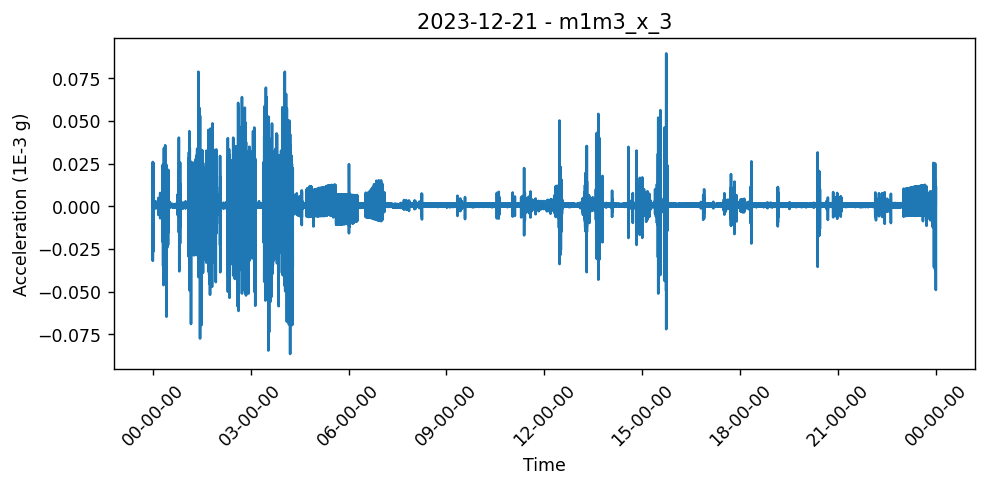

In [7]:
%matplotlib inline
# First look at the raw VMS data - We plot only 1 sensor and 1 axis because the full dataset is very large and requires too much memory
# to be displayed
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(8, 4))
key = "m1m3_x_3"
ax.plot(vms_m1m3_data["times"], vms_m1m3_data[key])
ax.set(ylabel="Acceleration (1E-3 g)", xlabel="Time", title=f"{vms_date} - {key}")
ax.xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
plt.setp(ax.get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/VMS-accel-{vms_date}.png")

In [8]:
# Retrieve TMA events corresponding to the VMS acquisition date
# As VMS and TMA do not cover the same time window, we need to get the TMA events corresponding to both
# dayObs and the day before dayObs
dayObs = int(vms_date.replace("-", "", 2))
vms_time = Time(vms_date + "T00:00:00")
delta_t = TimeDelta(1, format="jd")
day_before = int(str(vms_time - delta_t)[0:10].replace("-", "", 2))
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(day_before)
events = events + eventMaker.getEvents(dayObs)

# Get lists of slew events
slews = [e for e in events if e.type == TMAState.SLEWING]
print(f"Found {len(slews)} slews")

Found 1074 slews


In [9]:
# Filter the list of slews in order to keep the ones that are fully contained within the day corresponding to the VMS file.
date_min = Time(f"{vms_date} 00:00:00.00").unix
date_end = Time(f"{vms_date} 23:59:59.00").unix
sel_slews = [
    slews[i]
    for i in range(len(slews))
    if (slews[i].begin.unix > date_min and slews[i].end.unix < date_end)
]
print(f"Selected {len(sel_slews)} slews out of {len(slews)} for {dayObs}")

Selected 564 slews out of 1074 for 20231221


In [10]:
# Check that all the selected slews fall within dayObs
print(sel_slews[0].begin.datetime64, sel_slews[-1].end.datetime64)

2023-12-21T00:00:03.703244209 2023-12-21T23:59:41.575333118


In [11]:
# pos_columns = ["xPosition", "yPosition", "zPosition"]
# rot_columns = ["xRotation", "yRotation", "zRotation"]
# all_columns = pos_columns + rot_columns

In [12]:
client = EfdClient("usdf_efd")

In [13]:
# Print slews amplitudes and speed in azimuth and elevation
# This is intended to help selecting large slews that will be studied in details
# The selected slew numbers will be stored in variables slew_azi and slew_ele
# by default they contain the slews with the largest amplitudes
max_delta_azi = -99
max_delta_ele = -99
for i_slew, slew in enumerate(sel_slews):
    df_ele = getEfdData(client, "lsst.sal.MTMount.elevation", event=slew)
    df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", event=slew)

    t1 = slew.begin.datetime64
    t2 = slew.end.datetime64
    if len(df_ele) > 0:
        slew_delta_ele = df_ele["demandPosition"].max() - df_ele["demandPosition"].min()
        if slew_delta_ele > 30:
            print(
                f"Slew number: {i_slew} - Delta ele: {slew_delta_ele:.1f} degrees - Speed: {abs(df_ele['actualVelocity']).max()}",
                t1,
                t2,
            )
        if slew_delta_ele > max_delta_ele:
            max_delta_ele = slew_delta_ele
            slew_ele = i_slew
    if len(df_azi) > 0:
        slew_delta_azi = df_azi["actualPosition"].max() - df_azi["actualPosition"].min()
        if slew_delta_azi > 30:
            print(
                f"Slew number: {i_slew} - Delta azi: {slew_delta_azi:.1f} degrees - Speed: {abs(df_azi['actualVelocity']).max()}",
                t1,
                t2,
            )
        if slew_delta_azi > max_delta_azi:
            max_delta_azi = slew_delta_azi
            slew_azi = i_slew
print(
    f"Maximum amplitude slew in azimuth: {slew_azi} / {max_delta_azi:.1f} degrees - in elevation: {slew_ele} / {max_delta_ele:.1f} degrees"
)

Slew number: 22 - Delta azi: 52.0 degrees - Speed: 0.000878892108646331 2023-12-21T00:44:49.181732655 2023-12-21T00:46:13.757537842


Slew number: 28 - Delta azi: 63.3 degrees - Speed: 6.9975115170657 2023-12-21T00:50:15.594901323 2023-12-21T00:50:26.884445906
Slew number: 29 - Delta azi: 262.9 degrees - Speed: 7.01384610232146 2023-12-21T01:05:56.304308653 2023-12-21T01:06:36.236099720
Slew number: 62 - Delta azi: 88.9 degrees - Speed: 7.01587108739295 2023-12-21T01:31:26.524157286 2023-12-21T01:31:41.618402481


Slew number: 100 - Delta azi: 136.6 degrees - Speed: 7.0104243854145 2023-12-21T02:03:47.212932110 2023-12-21T02:04:09.068897486
Slew number: 134 - Delta azi: 108.1 degrees - Speed: 6.99813424967301 2023-12-21T02:43:01.310669422 2023-12-21T02:43:19.039031267
Slew number: 167 - Delta azi: 105.9 degrees - Speed: 7.00522832226416 2023-12-21T03:08:13.097789526 2023-12-21T03:08:30.550443649
Slew number: 168 - Delta azi: 106.8 degrees - Speed: 6.99932892463535 2023-12-21T03:24:00.106746197 2023-12-21T03:24:17.695680141
Slew number: 234 - Delta azi: 96.3 degrees - Speed: 7.00306421607963 2023-12-21T04:14:07.520389557 2023-12-21T04:14:23.541095972


Slew number: 241 - Delta azi: 77.3 degrees - Speed: 0.000647023587520968 2023-12-21T04:23:54.814126492 2023-12-21T04:25:16.992531061
Slew number: 245 - Delta azi: 72.0 degrees - Speed: 4.00396966266941 2023-12-21T04:34:01.772553921 2023-12-21T04:34:21.297022581
Slew number: 299 - Delta ele: 54.0 degrees - Speed: 2.00560115610784 2023-12-21T04:55:38.593890667 2023-12-21T04:56:07.124262571
Slew number: 422 - Delta azi: 153.0 degrees - Speed: 4.00295496185467 2023-12-21T06:31:35.368136644 2023-12-21T06:32:15.105501413
Slew number: 457 - Delta ele: 40.0 degrees - Speed: 0.503576293116318 2023-12-21T09:25:33.965584755 2023-12-21T09:27:32.936629772
Slew number: 457 - Delta azi: 118.0 degrees - Speed: 1.0041817119658 2023-12-21T09:25:33.965584755 2023-12-21T09:27:32.936629772


Slew number: 546 - Delta ele: 62.0 degrees - Speed: 2.00434714279949 2023-12-21T23:42:46.800276518 2023-12-21T23:43:19.312413454
Slew number: 557 - Delta ele: 37.0 degrees - Speed: 2.00479160321455 2023-12-21T23:54:02.090643168 2023-12-21T23:54:28.629716396
Slew number: 557 - Delta azi: 100.0 degrees - Speed: 4.00937330334385 2023-12-21T23:54:02.090643168 2023-12-21T23:54:28.629716396
Slew number: 558 - Delta azi: 200.0 degrees - Speed: 4.01159040805884 2023-12-21T23:54:40.955374718 2023-12-21T23:55:32.511086941
Slew number: 559 - Delta azi: 200.0 degrees - Speed: 4.00859378347424 2023-12-21T23:55:44.848711491 2023-12-21T23:56:36.350673437
Slew number: 560 - Delta azi: 200.0 degrees - Speed: 4.00744437807185 2023-12-21T23:56:48.685815573 2023-12-21T23:57:40.219945908
Slew number: 561 - Delta azi: 200.0 degrees - Speed: 4.00722244677762 2023-12-21T23:57:52.542374611 2023-12-21T23:58:44.113667965
Slew number: 562 - Delta azi: 90.0 degrees - Speed: 4.005274751195 2023-12-21T23:58:58.66004

In [86]:
print(sel_slews[558])
print(sel_slews[558].end.unix - sel_slews[558].begin.unix)
print(sel_slews[558].end.datetime64, sel_slews[558].begin.datetime64)

dayObs: 20231221
seqNum: 91
type: SLEWING
endReason: STOPPED
duration: 51.55571222305298
begin: <Time object: scale='utc' format='unix' value=1703202880.9553747>
end: <Time object: scale='utc' format='unix' value=1703202932.511087>
blockInfos: 
    dayObs: 20231221
    seqNum: 3
    blockNumber: 175
    blockId: BL175_O_20231221_000003
    begin: 2023-12-21T23:54:01.989
    end: 2023-12-21T23:58:56.358
    salIndices: [101657]
    tickets: []
    states: 
       RUNNING @ 2023-12-21T23:54:01.989  
       RUNNING @ 2023-12-21T23:54:01.990  
       RUNNING @ 2023-12-21T23:54:40.841  
       RUNNING @ 2023-12-21T23:55:44.749  
       RUNNING @ 2023-12-21T23:56:48.587  
       RUNNING @ 2023-12-21T23:57:52.454  
       RUNNING @ 2023-12-21T23:58:56.354  
        ENDING @ 2023-12-21T23:58:56.356  
          DONE @ 2023-12-21T23:58:56.358
51.55571222305298
2023-12-21T23:55:32.511086941 2023-12-21T23:54:40.955374718


In [14]:
# This is the slew that we are going to analyze
# slew_select = slew_azi
slew_select = 558

# Add a small delta_t before and after the selected slew
delta_t = TimeDelta(5, format="sec")
start_slew = sel_slews[slew_select].begin - delta_t
end_slew = sel_slews[slew_select].end + delta_t
print(f"Selected slew - start: {start_slew.datetime64} - end: {end_slew.datetime64}")

# Create a cut to pick up the interesting time window in the VMS dataframe
sel = (vms_m1m3_data["times"] > start_slew.datetime64) & (
    vms_m1m3_data["times"] < end_slew.datetime64
)

Selected slew - start: 2023-12-21T23:54:35.955374718 - end: 2023-12-21T23:55:37.511086941


In [15]:
df_azi = getEfdData(client, "lsst.sal.MTMount.azimuth", begin=start_slew, end=end_slew)
df_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", begin=start_slew, end=end_slew
)
min_azi = np.min(df_azi["actualPosition"])
max_azi = np.max(df_azi["actualPosition"])
min_ele = np.min(df_ele["actualPosition"])
max_ele = np.max(df_ele["actualPosition"])
speed_azi = np.max(np.abs(df_azi["actualVelocity"]))
if np.max(df_azi["actualVelocity"]) < speed_azi:
    speed_azi = -speed_azi
speed_ele = np.max(np.abs(df_ele["actualVelocity"]))
if np.max(df_ele["actualVelocity"]) < speed_ele:
    speed_ele = -speed_ele

print(len(df_azi), len(df_ele))

818 818


In [16]:
# Get accelerometer data
df_accel = getEfdData(
    client, "lsst.sal.MTM1M3.accelerometerData", begin=start_slew, end=end_slew
)

In [17]:
# Retrieve the events occuring around the slew of interest
selected = [ev for ev in events if ev.begin > start_slew and ev.end < end_slew]
selected

[TMAEvent(dayObs=20231221, seqNum=91, type=TMAState.SLEWING, endReason=TMAState.STOPPED, duration=51.55571222305298, begin=<Time object: scale='utc' format='unix' value=1703202880.9553747>, end=<Time object: scale='utc' format='unix' value=1703202932.511087>]

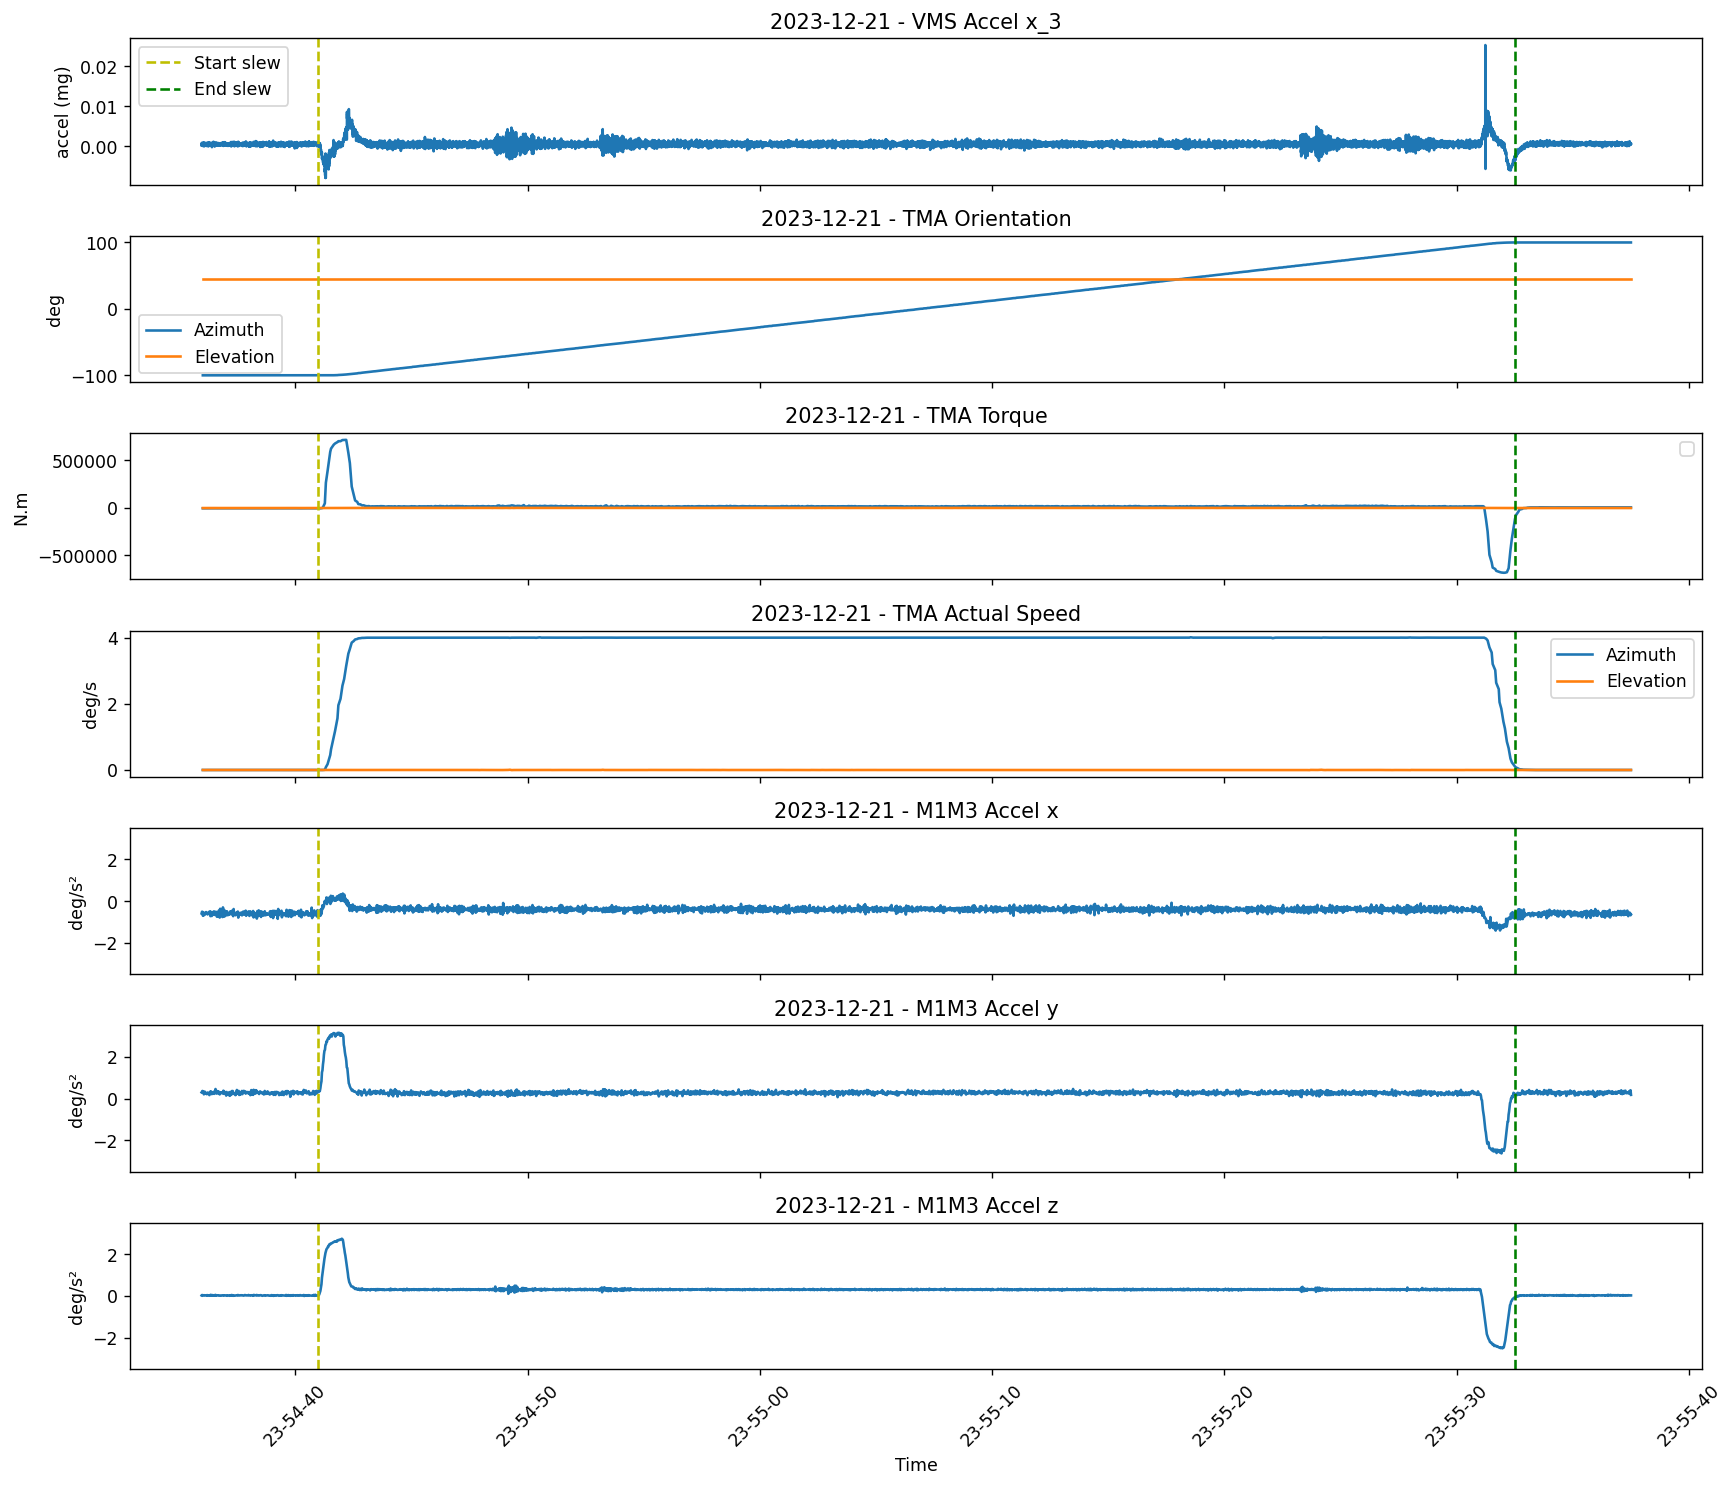

In [19]:
# Plot a few quantities to check that we have selected a good quality slew

fig, ax = plt.subplots(7, 1, sharex=True, dpi=125, figsize=(14, 12))
ax[0].plot(vms_m1m3_data["times"][sel], vms_m1m3_data["m1m3_x_3"][sel])
ax[0].set(ylabel="accel (mg)", title=f"{vms_date} - VMS Accel x_3")
ax[1].plot(df_azi.index, df_azi["actualPosition"], label="Azimuth")
ax[1].plot(df_ele.index, df_ele["actualPosition"], label="Elevation")
ax[1].legend()
ax[1].set(ylabel="deg", title=f"{vms_date} - TMA Orientation")
ax[2].plot(df_azi.index, df_azi["actualTorque"])
ax[2].plot(df_ele.index, df_ele["actualTorque"])
ax[2].set(ylabel="N.m", title=f"{vms_date} - TMA Torque")
ax[2].legend()
ax[3].plot(df_azi.index, df_azi["actualVelocity"], label="Azimuth")
ax[3].plot(df_ele.index, df_ele["actualVelocity"], label="Elevation")
ax[3].set(ylabel="deg/s", title=f"{vms_date} - TMA Actual Speed")
ax[3].legend()
ax[4].plot(df_accel.index, df_accel["angularAccelerationX"])
ax[4].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel x")
ax[4].set_ylim([-3.5, 3.5])
ax[5].plot(df_accel.index, df_accel["angularAccelerationY"])
ax[5].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel y")
ax[5].set_ylim([-3.5, 3.5])
ax[6].plot(df_accel.index, df_accel["angularAccelerationZ"])
ax[6].set(ylabel="deg/s²", title=f"{vms_date} - M1M3 Accel z")
ax[6].set_ylim([-3.5, 3.5])
ax[len(ax) - 1].set_xlabel("Time")
for i in range(len(ax)):
    ax[i].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
    plt.setp(ax[i].get_xticklabels(), rotation=45)
    for ct, ev in enumerate(selected):
        if i == 0 and ct == 0:
            ax[i].axvline(ev.begin.datetime64, color="y", ls="--", label="Start slew")
            ax[i].axvline(ev.end.datetime64, color="g", ls="--", label="End slew")
            ax[0].legend()
        else:
            ax[i].axvline(ev.begin.datetime64, color="y", ls="--")
            ax[i].axvline(ev.end.datetime64, color="g", ls="--")
    if i == 0:
        ax[0].legend(loc="upper left")
fig.tight_layout()
fig.savefig(f"{plot_dir}/overview-{vms_date}-{slew_select}-.png")

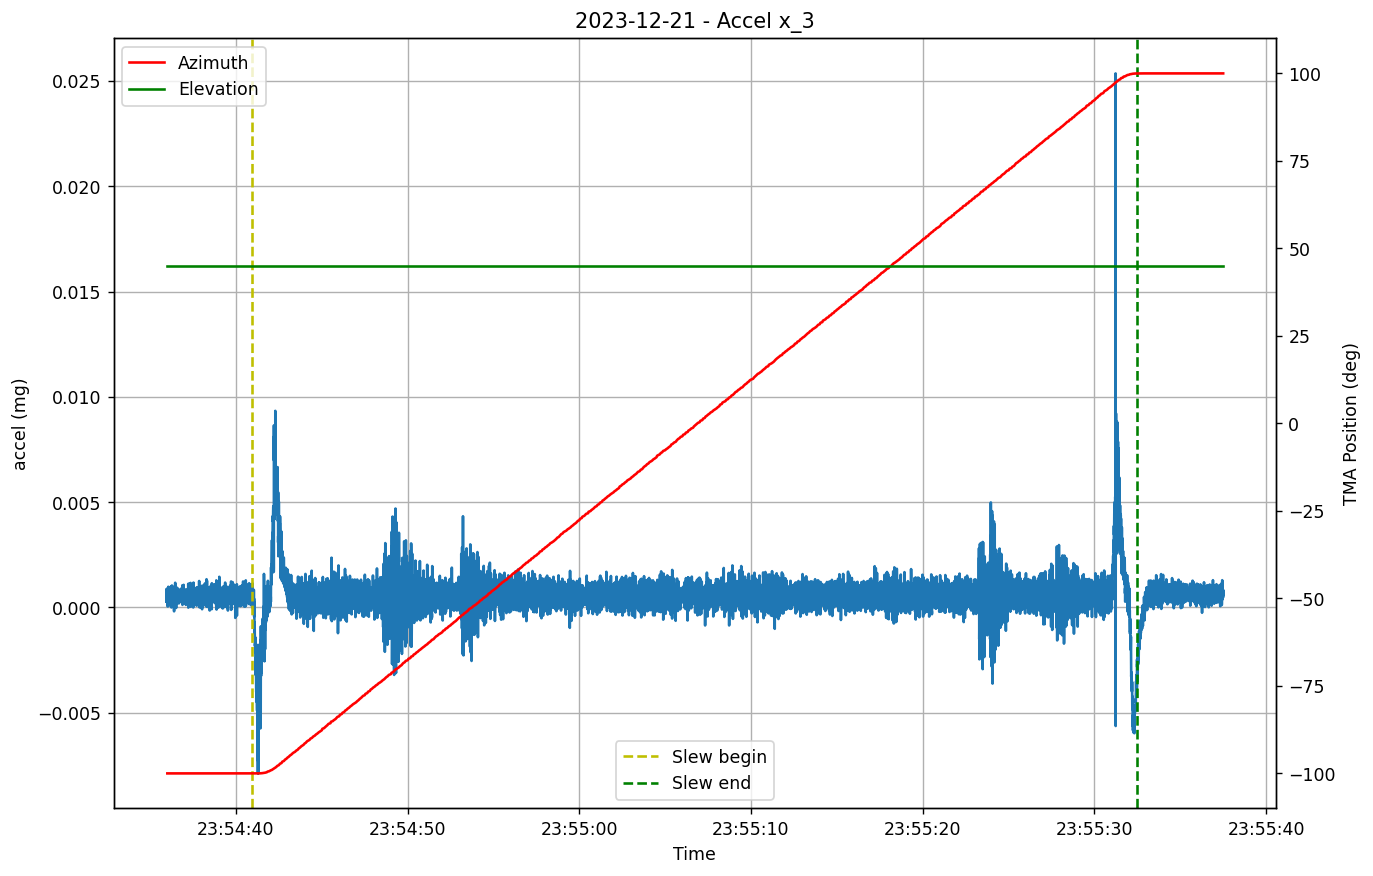

In [20]:
# Zoom in the acceleration measured by the VMS
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(12, 8))
ax.plot(vms_m1m3_data["times"][sel], vms_m1m3_data["m1m3_x_3"][sel])
ax.set(ylabel="accel (mg)", xlabel="Time", title=f"{vms_date} - Accel x_3")
ax2 = ax.twinx()
ax2.plot(df_azi.index, df_azi["actualPosition"], c="red", label="Azimuth")
ax2.plot(df_ele.index, df_ele["actualPosition"], c="green", label="Elevation")
ax2.set_ylabel("TMA Position (deg)")
ax2.legend()
for i, ev in enumerate(selected):
    ax.axvline(ev.begin.datetime64, color="y", ls="--", label="Slew begin")
    ax.axvline(ev.end.datetime64, color="g", ls="--", label="Slew end")
    if i == 0:
        ax.legend()
ax.grid(axis="both")

We see that on top of the acceleration / deceleration phase the VMS is recording 4 sequences of vibrations (glitches) that occur while the TMA is rotating at constant speed.

## Check whether HP forces are correlated with VMS data

In [21]:
df_hp = getEfdData(
    client, "lsst.sal.MTM1M3.hardpointActuatorData", begin=start_slew, end=end_slew
)

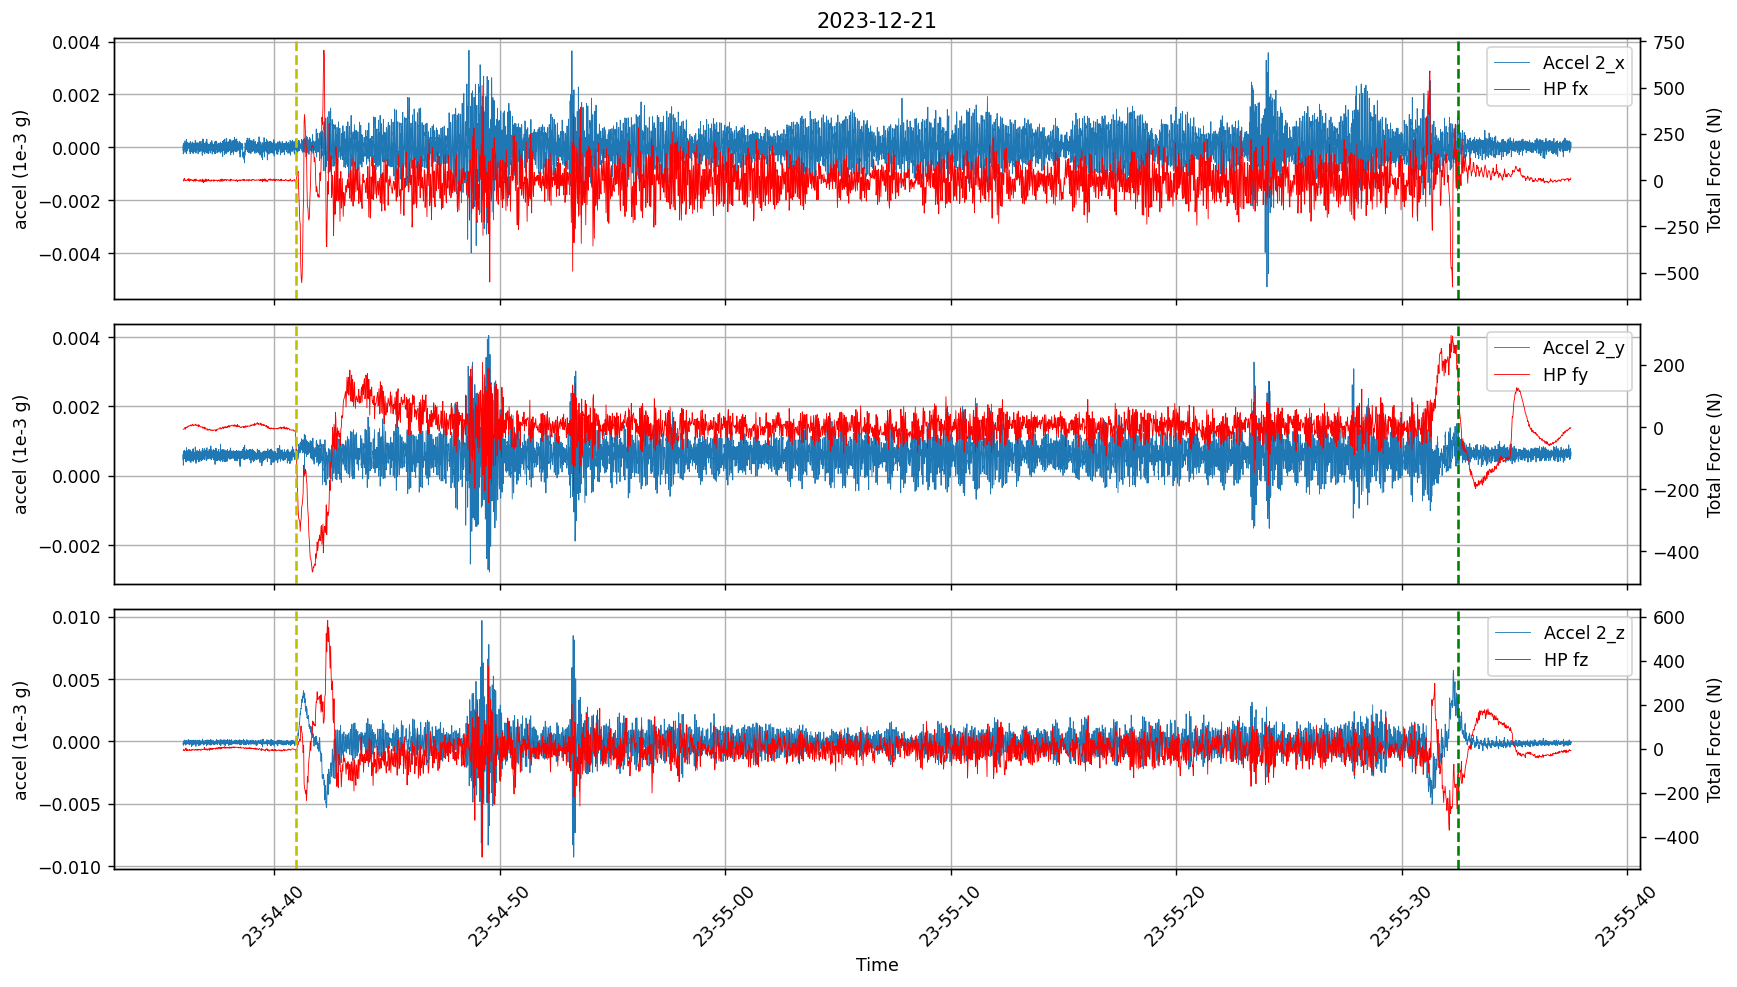

In [22]:
fig, ax = plt.subplots(3, 1, sharex=True, dpi=125, figsize=(14, 8))
bx = []
for i, axis in enumerate("xyz"):
    lns1 = ax[i].plot(
        vms_m1m3_data["times"][sel],
        vms_m1m3_data[f"m1m3_{axis}_2"][sel],
        lw=0.5,
        label=f"Accel 2_{axis}",
    )
    ax[i].set(ylabel="accel (1e-3 g)")
    bx.append(ax[i].twinx())
    lns2 = bx[i].plot(
        df_hp.index, df_hp[f"f{axis}"], c="red", lw=0.5, label=f"HP f{axis}"
    )
    bx[i].set_ylabel(f"Total Force (N)")
    ax[i].grid(axis="both")
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax[i].legend(lns, labs)
    for ct, ev in enumerate(selected):
        if i == 0 and ct == 0:
            bx[i].axvline(ev.begin.datetime64, color="y", ls="--", label="Start slew")
            bx[i].axvline(ev.end.datetime64, color="g", ls="--", label="End slew")
        else:
            bx[i].axvline(ev.begin.datetime64, color="y", ls="--")
            bx[i].axvline(ev.end.datetime64, color="g", ls="--")
ax[2].set(xlabel="Time")
ax[0].set(title=f"{vms_date}")
ax[2].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
plt.setp(ax[i].get_xticklabels(), rotation=45)
fig.tight_layout()

We see that the first 2 glitches around 23:54:50 are obvious in the HP forces, the 2 others around 23:55:25 are much less visible

### Find glitches in accelerometer data
In the following we are going to analyse the data from one axis of a single accelerometer in order to identify glitches
and locate the associated TMA positions

In [49]:
# We select the vms data corresponding to the slew duration cutting out the acceleration and deceleration phases

delta_t = TimeDelta(5, format="sec")
start_slew_strict = sel_slews[slew_select].begin + delta_t
end_slew_strict = sel_slews[slew_select].end - delta_t

sel_strict = (vms_m1m3_data["times"] > start_slew_strict.datetime64) & (
    vms_m1m3_data["times"] < end_slew_strict.datetime64
)

# We apply a high pass filter to remove the low frequency noise
sos = signal.butter(8, 20, "high", fs=200, output="sos")
filtered = signal.sosfilt(sos, vms_m1m3_data["m1m3_x_1"][sel_strict])

# We subtract the mean value and take the square of the signal in order to have positive values only
accel = (filtered - np.mean(filtered)) ** 2

In [54]:
# The VMS data are sampled at 200 Hz, so we rebin the signal in order to limit the
# fluctuations and reinforce the peaks.

accel_rebin = []
t_rebin = []
for p in range(0, len(accel), 20):
    sum = np.sum(accel[p : p + 20])
    accel_rebin.append(sum)
    if p + 9 < len(accel):
        t_rebin.append(vms_m1m3_data["times"][sel_strict].values[p + 9])
    else:
        t_rebin.append(vms_m1m3_data["times"][sel_strict].values[len(accel) - 1])

# We normalize the signal to 1
norm = np.max(accel_rebin)
accel_rebin = accel_rebin / norm

In [55]:
len(accel)

8310

In [59]:
# We detects the position of the peaks in the signal
peaks, _ = signal.find_peaks(accel_rebin, prominence=0.08, distance=5)
t_peak = [t_rebin[ll] for ll in peaks]
y_peak = np.full(len(t_peak), 0.8)
print(f"{len(t_peak)} peaks detected in signal")

5 peaks detected in signal


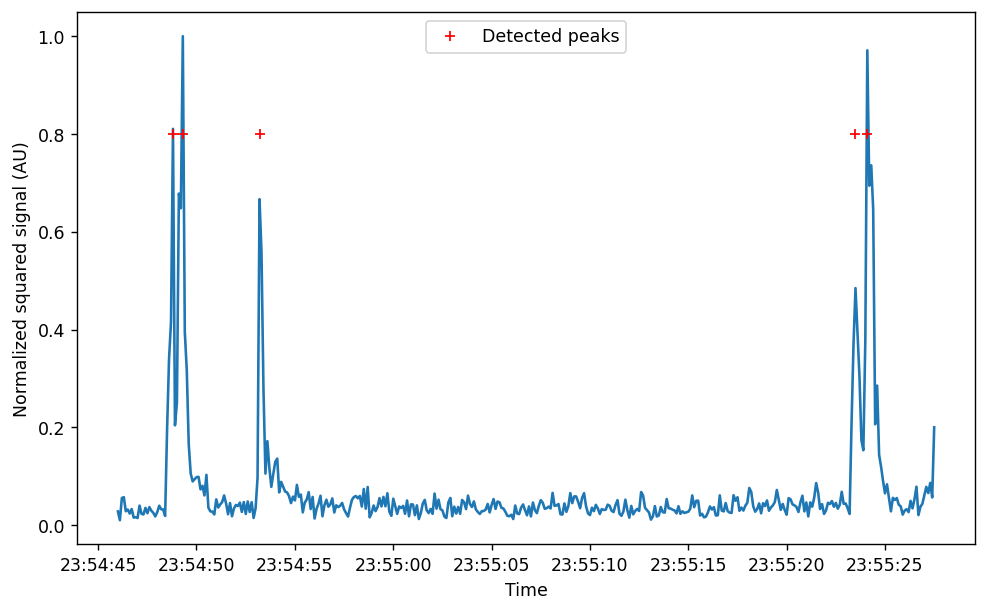

In [60]:
# We plot the signal and the detected peak positions in order to check
# that the peak detection makes sense
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(8, 5))
ax.plot(t_rebin, accel_rebin)
ax.plot(t_peak, y_peak, "r+", label="Detected peaks")
ax.set_xlabel("Time")
ax.set_ylabel("Normalized squared signal (AU)")
ax.legend()
fig.tight_layout()

In [61]:
# We find the time stamps corresponding to the peaks
locate = df_azi.index.tz_localize(None).get_indexer(t_peak, method="nearest")

# We determine the TMA positions corresponding to the glitches
glitches_azi = [df_azi["actualPosition"].iloc[k] for k in locate]
glitches_ele = [df_ele["actualPosition"].iloc[k] for k in locate]

date = sel_slews[slew_select].begin.datetime.replace(microsecond=0)
seqNum = sel_slews[slew_select].seqNum
np.set_printoptions(precision=1)
print(f"\nStart date: {date} - seqNum: {seqNum} - slew number: {slew_select}")
print(
    f"Azimuth: {min_azi:.0f} : {max_azi:.0f} / Elevation: {min_ele:.0f} : {max_ele:.0f}"
)
print(f"TMA speed - Azimuth: {speed_azi:.0f} deg/s - Elevation: {speed_ele:.0f} deg/s")
print(f"Glitches correspond to the following TMA positions:")
print(f"    o in Azimuth:  {np.array(glitches_azi)} degrees")
print(f"    o and in Elevation: {np.array(glitches_ele)} degrees\n")


Start date: 2023-12-21 23:54:40 - seqNum: 91 - slew number: 558
Azimuth: -100 : 100 / Elevation: 45 : 45
TMA speed - Azimuth: 4 deg/s - Elevation: 0 deg/s
Glitches correspond to the following TMA positions:
    o in Azimuth:  [-72.5 -70.3 -54.7  66.3  68.7] degrees
    o and in Elevation: [45. 45. 45. 45. 45.] degrees



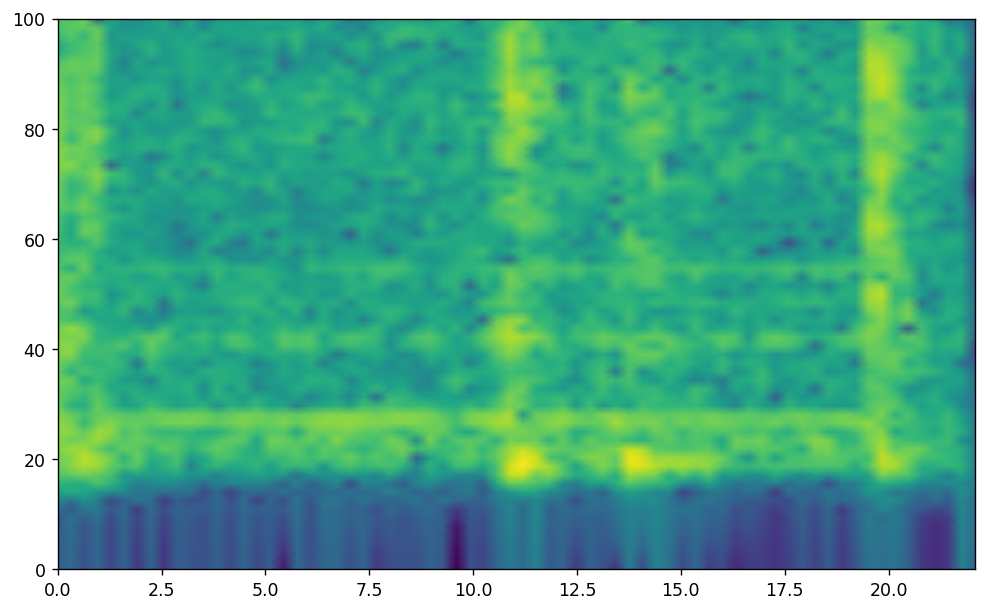

In [29]:
fs = 200
f1, t1, Zxx1 = stft(filtered, fs, "hamming", 128, scaling="psd")

fig, ax = plt.subplots(1, 1, dpi=125, figsize=(8, 5))
pcm = ax.pcolormesh(
    t1, f1, np.abs(Zxx1), shading="gouraud", norm=matplotlib.colors.LogNorm()
)
fig.tight_layout()

In [30]:
from scipy import signal

b, a = signal.butter(8, 50, "high", analog=True)
w, h = signal.freqs(b, a)

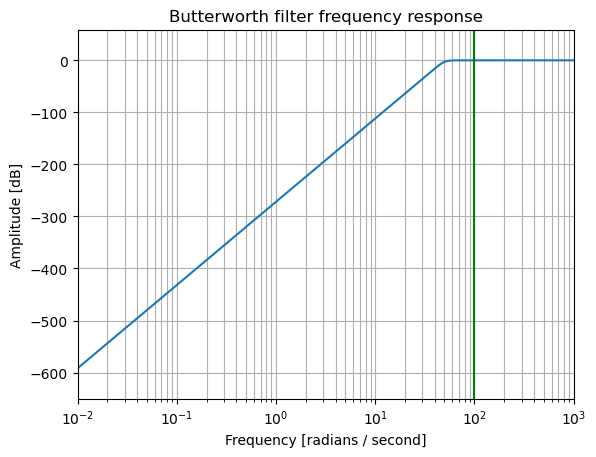

In [31]:
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title("Butterworth filter frequency response")
plt.xlabel("Frequency [radians / second]")
plt.ylabel("Amplitude [dB]")
plt.margins(0, 0.1)
plt.grid(which="both", axis="both")
plt.axvline(100, color="green")  # cutoff frequency

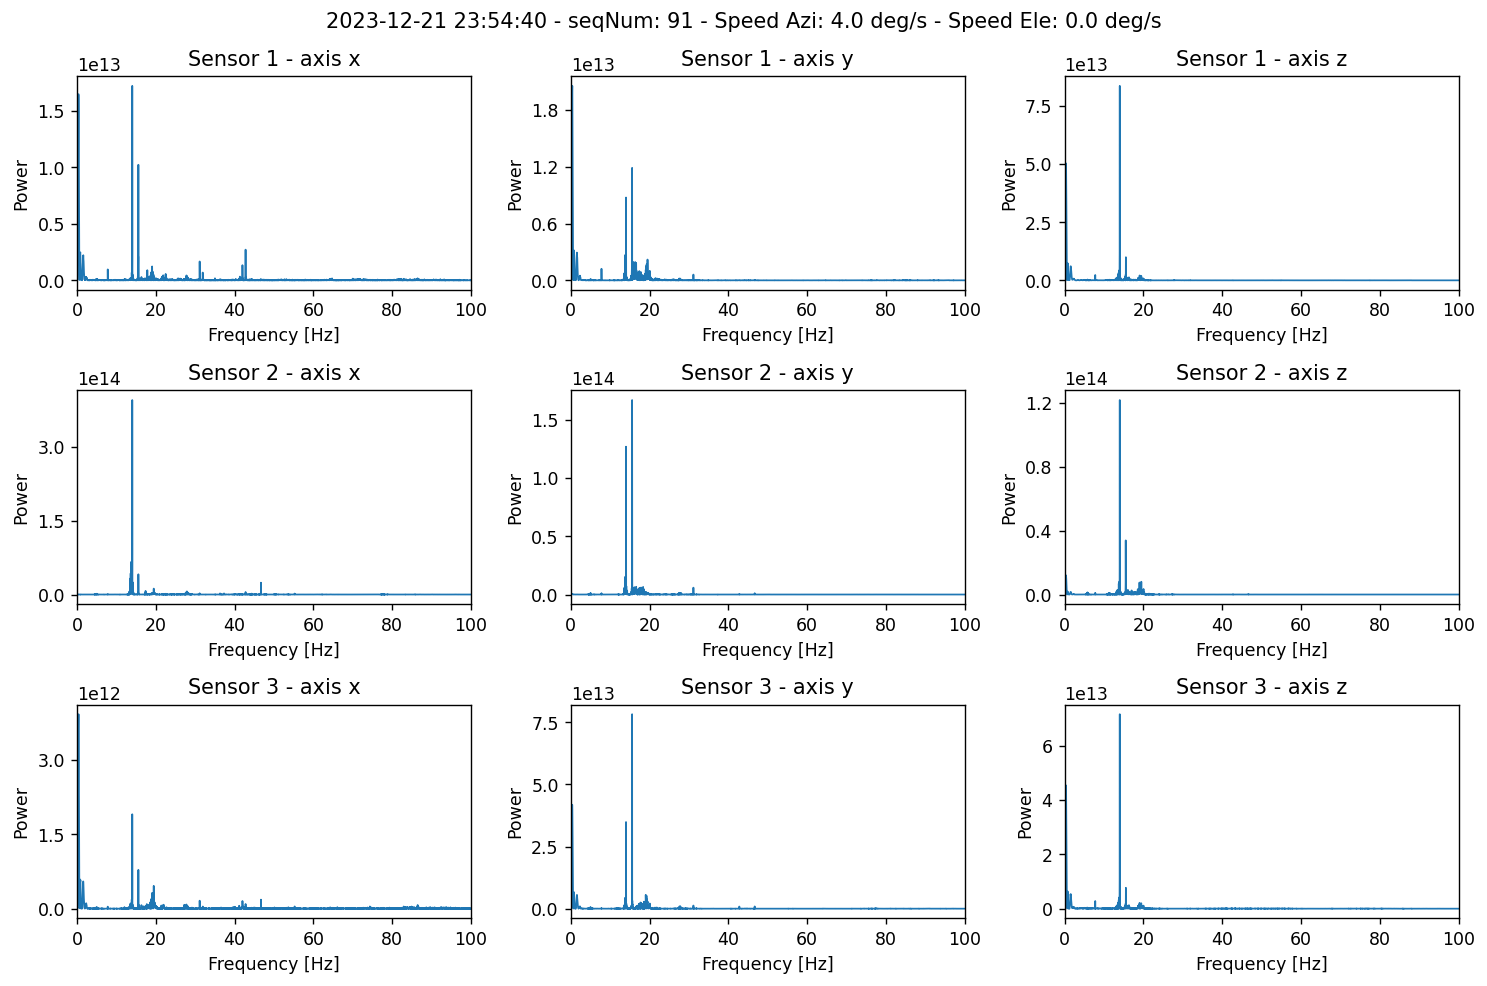

In [72]:
# Simple Fourier analysis

begin = sel_slews[slew_select].begin
end = sel_slews[slew_select].end

fig, ax = plt.subplots(3, 3, dpi=125, figsize=(12, 8))
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"
        norm_signal = np.int16((subdat[key] / subdat[key].max()) * 32767)
        sig_fft = rfft(norm_signal)
        sample_freq = rfftfreq(
            len(subdat[key]), np.mean(np.diff(Time(subdat["times"]).unix))
        )
        power = np.abs(sig_fft) ** 2

        # Cut the first bins in frequency to avoid the large peak close to 0 Hz
        ax[c][j].plot(sample_freq[2:], power[2:], lw=1)
        ax[c][j].set_xticks(np.arange(0, 110, 10))
        ax[c][j].set(
            ylabel="Power",
            xlabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
        yticks = ticker.MaxNLocator(4)
        ax[c][j].yaxis.set_major_locator(yticks)
        xticks = ticker.MaxNLocator(6)
        ax[c][j].xaxis.set_major_locator(xticks)
        ax[c][j].set_xlim([0, 100])
        # ax[c][j].set_ylim([0, 1e-6])
        # ax[c][j].set_yscale("log")
# fig.suptitle(f"FCU speed: {percentv}%")
date = sel_slews[slew_select].begin.datetime.replace(microsecond=0)
seqNum = sel_slews[slew_select].seqNum
speed_azi = abs(df_azi["actualVelocity"]).max()
speed_ele = abs(df_ele["actualVelocity"]).max()
fig.suptitle(
    f"{date} - seqNum: {seqNum} - Speed Azi: {speed_azi:.1f} deg/s - Speed Ele: {speed_ele:.1f} deg/s"
)
fig.tight_layout()

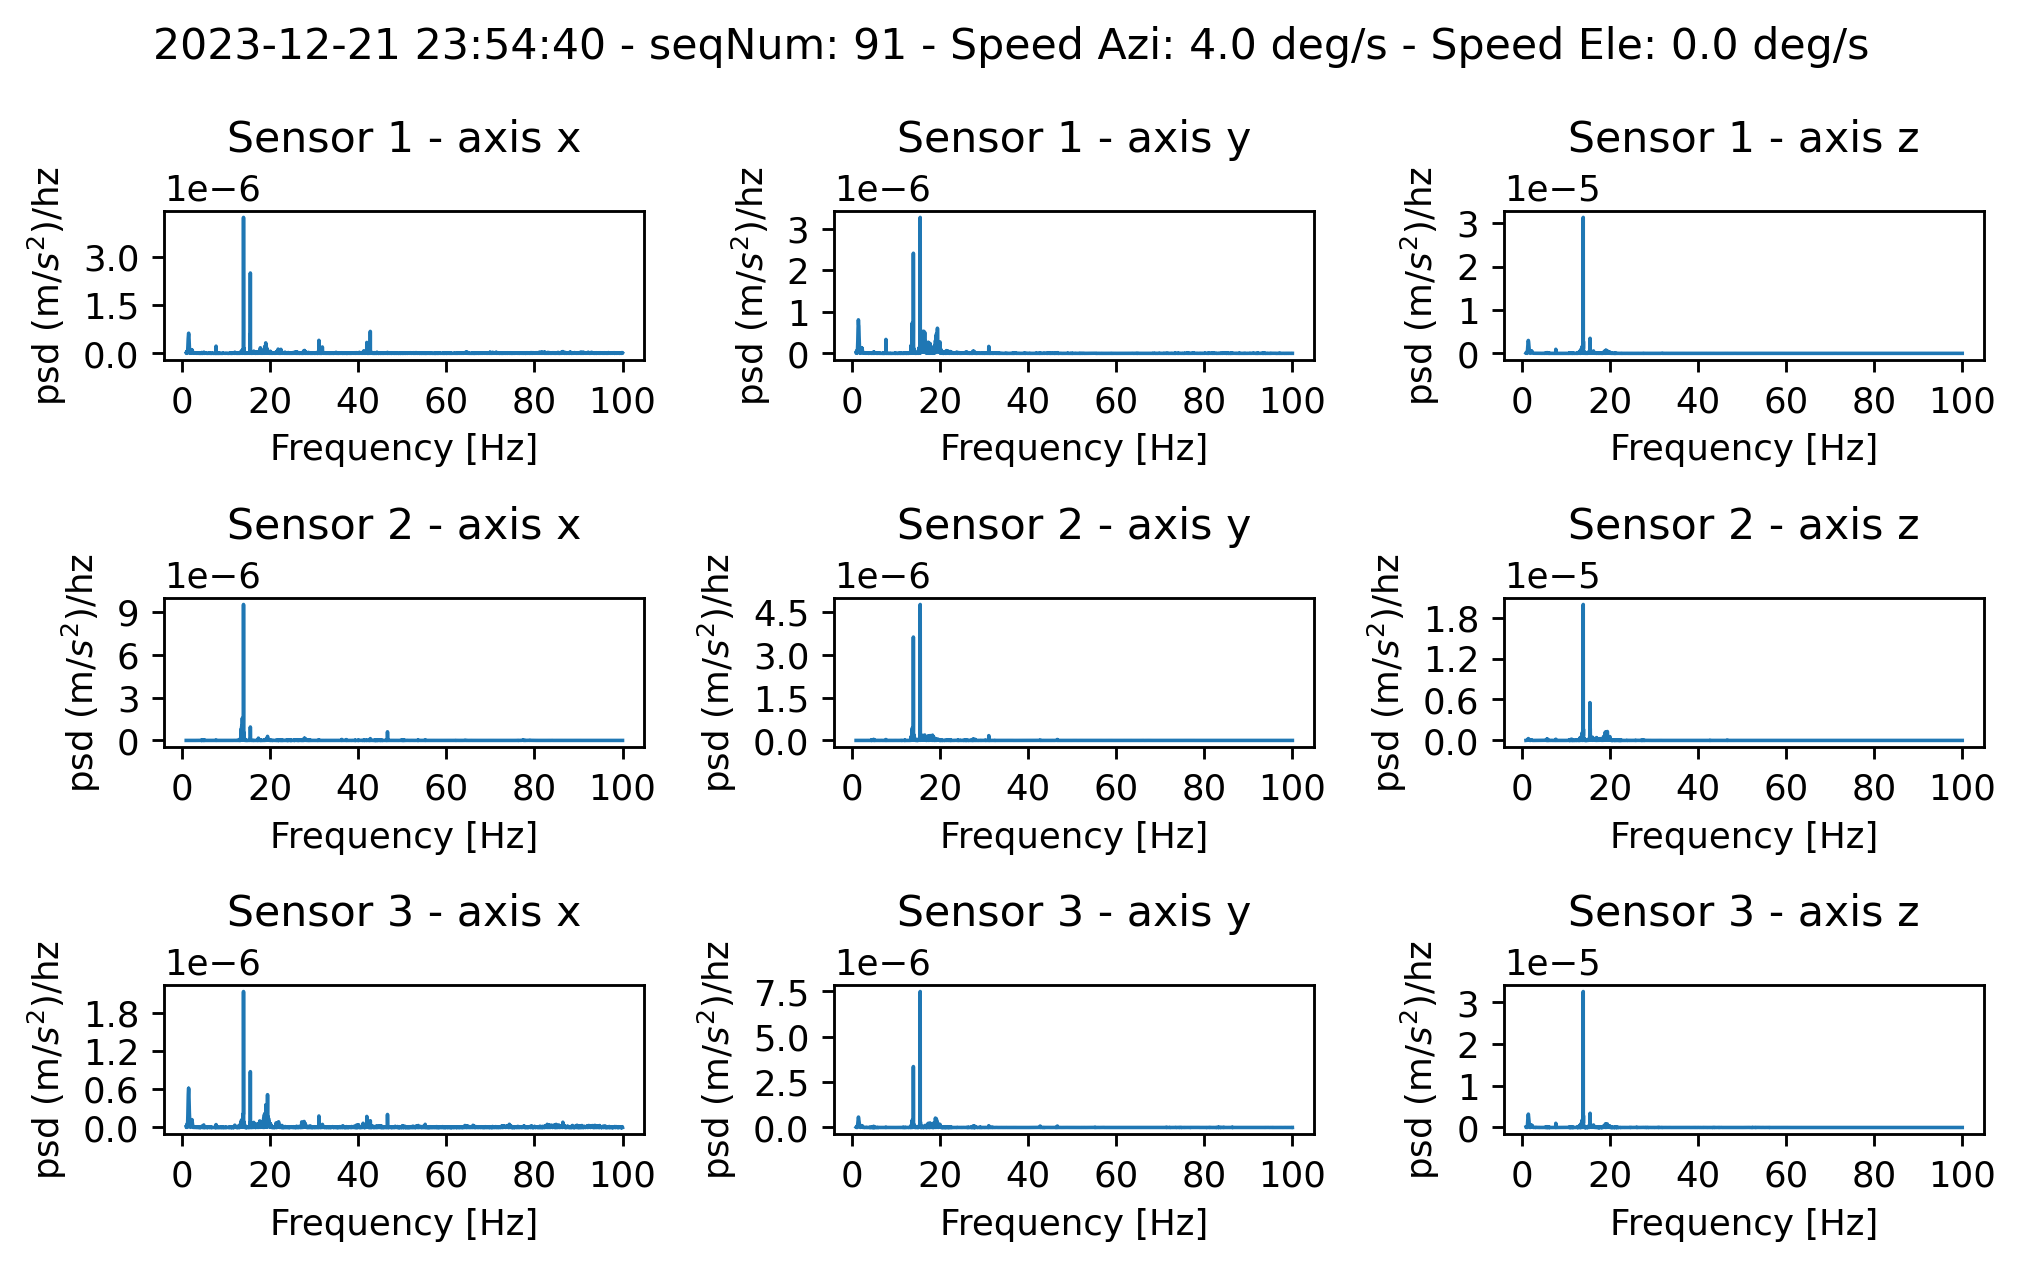

In [73]:
# PSD analysis

begin = sel_slews[slew_select].begin
end = sel_slews[slew_select].end

df_azi = getEfdData(
    client,
    "lsst.sal.MTMount.azimuth",
    begin=begin,
    end=end,
)
df_ele = getEfdData(
    client,
    "lsst.sal.MTMount.elevation",
    begin=begin,
    end=end,
)

fig, ax = plt.subplots(3, 3, dpi=256, figsize=(8, 5))
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"
        psds_df, disp = get_psd_and_dsd_for_vms(
            subdat[key],
            np.mean(np.diff(Time(subdat["times"]).unix)),
            g=True,
            min_freq=1,
        )

        x = psds_df["freq"]
        y = psds_df["accel_psd"]
        ax[c][j].plot(x, y, zorder=9, lw=1)
        ax[c][j].set_xticks(np.arange(0, 110, 10))
        ax[c][j].set(
            ylabel="psd (m/$s^2$)/hz",
            xlabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
        yticks = ticker.MaxNLocator(4)
        ax[c][j].yaxis.set_major_locator(yticks)
        xticks = ticker.MaxNLocator(6)
        ax[c][j].xaxis.set_major_locator(xticks)
        # ax[c][j].set_ylim([0, 1e-5])
        # ax[c][j].set_ylim([0, 1e-6])
        # ax[c][j].set_yscale("log")
# fig.suptitle(f"FCU speed: {percentv}%")
date = sel_slews[slew_select].begin.datetime.replace(microsecond=0)
seqNum = sel_slews[slew_select].seqNum
speed_azi = abs(df_azi["actualVelocity"]).max()
speed_ele = abs(df_ele["actualVelocity"]).max()
fig.suptitle(
    f"{date} - seqNum: {seqNum} - Speed Azi: {speed_azi:.1f} deg/s - Speed Ele: {speed_ele:.1f} deg/s"
)
fig.tight_layout()
fig.savefig(f"{plot_dir}/psd-{vms_date}-{slew_select}-.png")

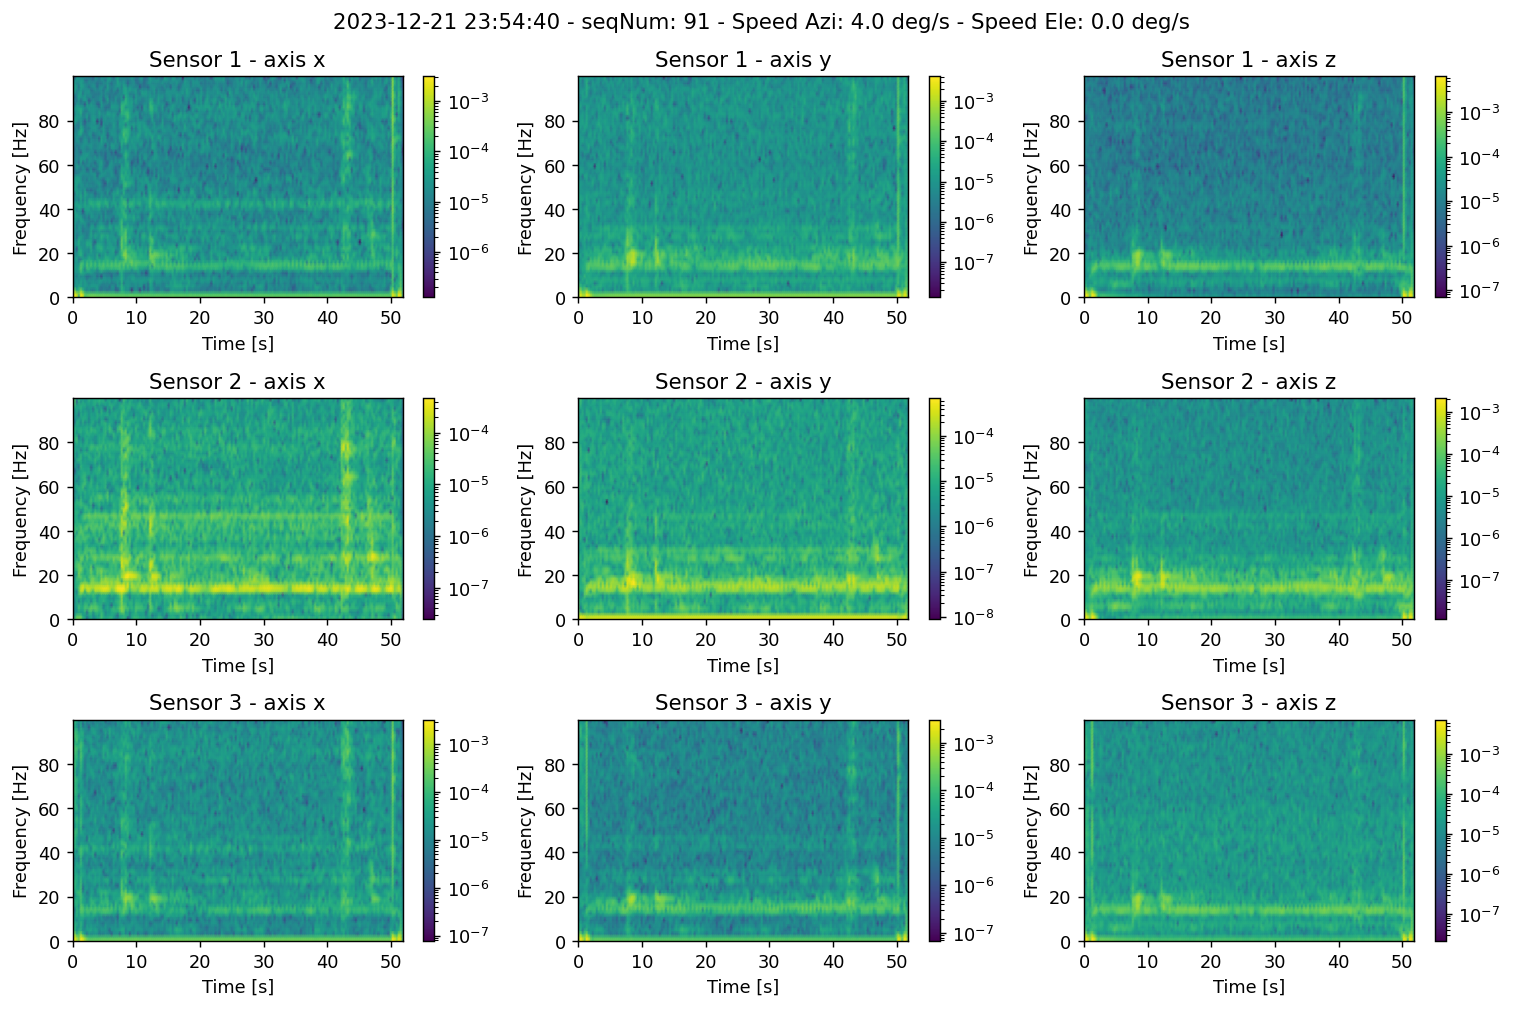

In [76]:
# Spectrograms

begin = sel_slews[slew_select].begin
end = sel_slews[slew_select].end

df_azi = getEfdData(
    client,
    "lsst.sal.MTMount.azimuth",
    begin=begin,
    end=end,
)
df_ele = getEfdData(
    client,
    "lsst.sal.MTMount.elevation",
    begin=begin,
    end=end,
)

fig, ax = plt.subplots(3, 3, dpi=128, figsize=(12, 8))
ax2 = ax
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    fs = 1 / np.mean(np.diff(Time(subdat["times"]).unix))
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"

        f, t, Zxx = stft(subdat[key], fs, "hamming", 128, scaling="psd")

        pcm = ax[c][j].pcolormesh(
            t, f, np.abs(Zxx), shading="gouraud", norm=matplotlib.colors.LogNorm()
        )
        ax[c][j].set(
            xlabel="Time [s]",
            ylabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
        fig.colorbar(pcm, ax=ax[c][j])

date = sel_slews[slew_select].begin.datetime.replace(microsecond=0)
seqNum = sel_slews[slew_select].seqNum
speed_azi = abs(df_azi["actualVelocity"]).max()
speed_ele = abs(df_ele["actualVelocity"]).max()
fig.suptitle(
    f"{date} - seqNum: {seqNum} - Speed Azi: {speed_azi:.1f} deg/s - Speed Ele: {speed_ele:.1f} deg/s"
)
fig.tight_layout()
fig.savefig(f"{plot_dir}/spectrogram-{vms_date}-{slew_select}-.png")

We see that the glitches appear has vertical lines in the spectrogram extending from ~20 Hz up to ~80-100 Hz

In [35]:
# Explore the slew events in order to find a sufficiently long period of time during which the TMA is still
for i in range(len(sel_slews) - 1):
    t1 = sel_slews[i].end.unix
    t2 = sel_slews[i + 1].begin.unix
    delta_t = t2 - t1
    if delta_t > 100:
        print(
            f"Between slew {i} and slew {i+1} the TMA is still during {delta_t:.0f} seconds"
        )

Between slew 2 and slew 3 the TMA is still during 765 seconds
Between slew 4 and slew 5 the TMA is still during 197 seconds
Between slew 20 and slew 21 the TMA is still during 736 seconds
Between slew 21 and slew 22 the TMA is still during 196 seconds
Between slew 28 and slew 29 the TMA is still during 929 seconds
Between slew 95 and slew 96 the TMA is still during 223 seconds
Between slew 100 and slew 101 the TMA is still during 836 seconds
Between slew 167 and slew 168 the TMA is still during 930 seconds
Between slew 239 and slew 240 the TMA is still during 280 seconds
Between slew 244 and slew 245 the TMA is still during 149 seconds
Between slew 245 and slew 246 the TMA is still during 531 seconds
Between slew 298 and slew 299 the TMA is still during 261 seconds
Between slew 421 and slew 422 the TMA is still during 944 seconds
Between slew 422 and slew 423 the TMA is still during 122 seconds
Between slew 423 and slew 424 the TMA is still during 132 seconds
Between slew 424 and slew 

In [36]:
delta_t = TimeDelta(20, format="sec")
# 245 - 298 - 436 - 484
sel_quiescent = 484
begin_quiescent = sel_slews[sel_quiescent].end + delta_t
end_quiescent = sel_slews[sel_quiescent + 1].begin - delta_t

print(begin_quiescent.datetime64, end_quiescent.datetime64)

sel_quiescent = (vms_m1m3_data["times"] > begin_quiescent.datetime64) & (
    vms_m1m3_data["times"] < end_quiescent.datetime64
)

df_azi = getEfdData(
    client, "lsst.sal.MTMount.azimuth", begin=begin_quiescent, end=end_quiescent
)
df_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", begin=begin_quiescent, end=end_quiescent
)
print(len(df_azi), len(df_ele))

2023-12-21T22:37:41.566636086 2023-12-21T23:00:31.508164644
18502 18502


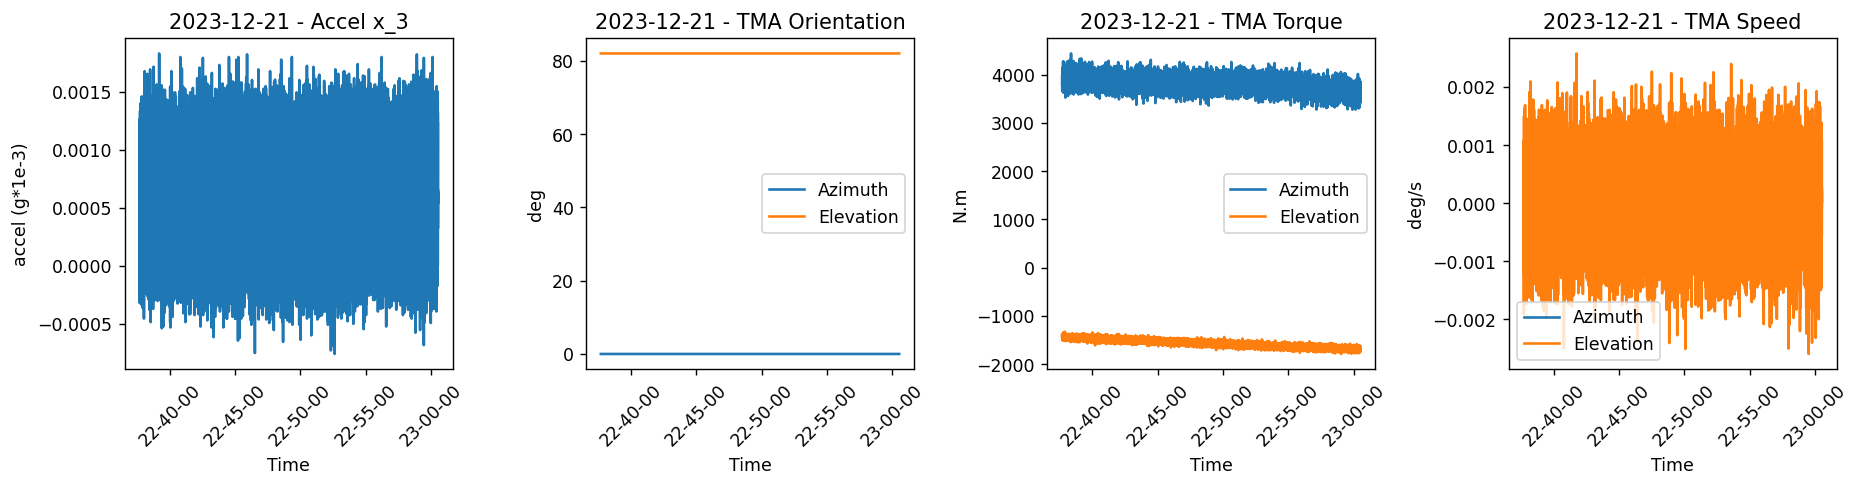

In [37]:
fig, ax = plt.subplots(1, 4, dpi=125, figsize=(15, 4))
ax[0].plot(
    vms_m1m3_data["times"][sel_quiescent], vms_m1m3_data["m1m3_x_3"][sel_quiescent]
)
ax[0].set(ylabel="accel (g*1e-3)", xlabel="Time", title=f"{vms_date} - Accel x_3")
ax[1].plot(df_azi.index, df_azi["actualPosition"], label="Azimuth")
ax[1].plot(df_ele.index, df_ele["actualPosition"], label="Elevation")
ax[1].legend()
ax[1].set(ylabel="deg", xlabel="Time", title=f"{vms_date} - TMA Orientation")
ax[2].plot(df_azi.index, df_azi["actualTorque"], label="Azimuth")
ax[2].plot(df_ele.index, df_ele["actualTorque"], label="Elevation")
ax[2].set(ylabel="N.m", xlabel="Time", title=f"{vms_date} - TMA Torque")
ax[2].legend()
ax[3].plot(df_azi.index, df_azi["actualVelocity"], label="Azimuth")
ax[3].plot(df_ele.index, df_ele["actualVelocity"], label="Elevation")
ax[3].set(ylabel="deg/s", xlabel="Time", title=f"{vms_date} - TMA Speed")
ax[3].legend()
for i in range(4):
    ax[i].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
    plt.setp(ax[i].get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/overview-still-{vms_date}.png")

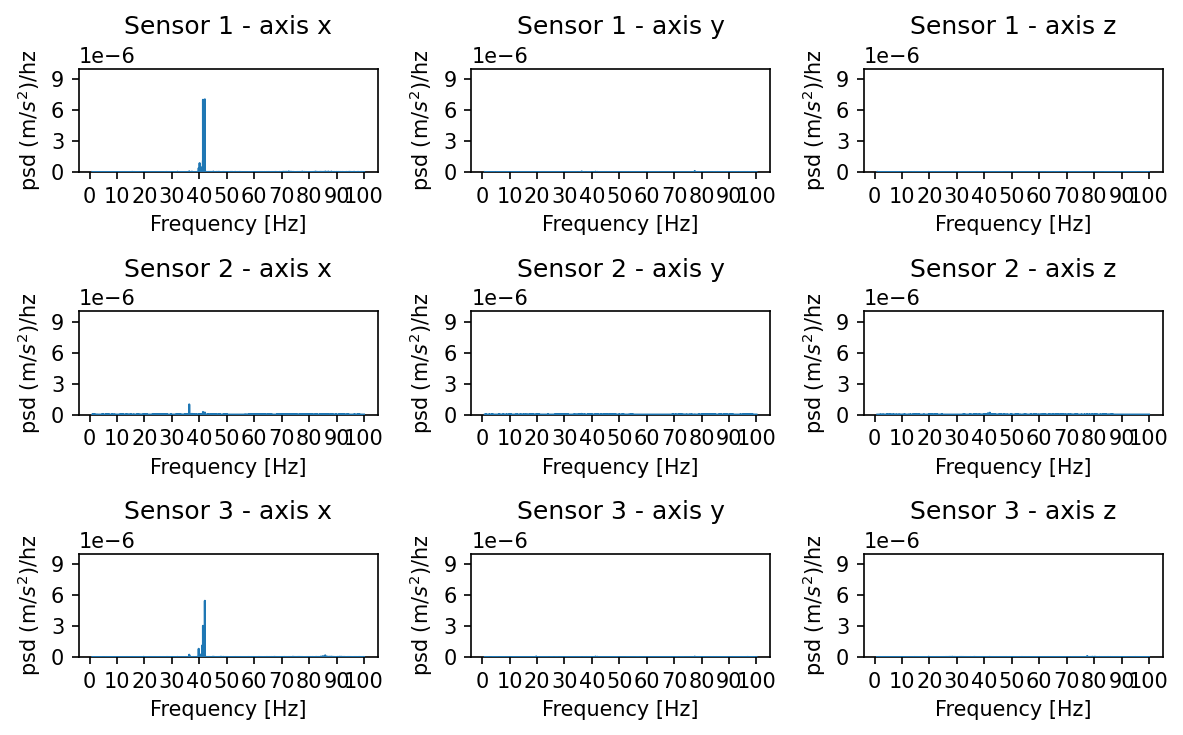

In [38]:
begin = begin_quiescent
end = end_quiescent

fig, ax = plt.subplots(3, 3, dpi=150, figsize=(8, 5))
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"
        psds_df, disp = get_psd_and_dsd_for_vms(
            subdat[key],
            np.mean(np.diff(Time(subdat["times"]).unix)),
            g=True,
            min_freq=1,
        )

        x = psds_df["freq"]
        y = psds_df["accel_psd"]
        ax[c][j].plot(x, y, zorder=9, lw=1)
        ax[c][j].set_xticks(np.arange(0, 110, 10))
        ax[c][j].set(
            ylabel="psd (m/$s^2$)/hz",
            xlabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
        yticks = ticker.MaxNLocator(4)
        ax[c][j].yaxis.set_major_locator(yticks)
        ax[c][j].set_ylim([0, 1e-5])
        # ax[c][j].set_yscale("log")
# fig.suptitle(f"FCU speed: {percentv}%")
fig.tight_layout()

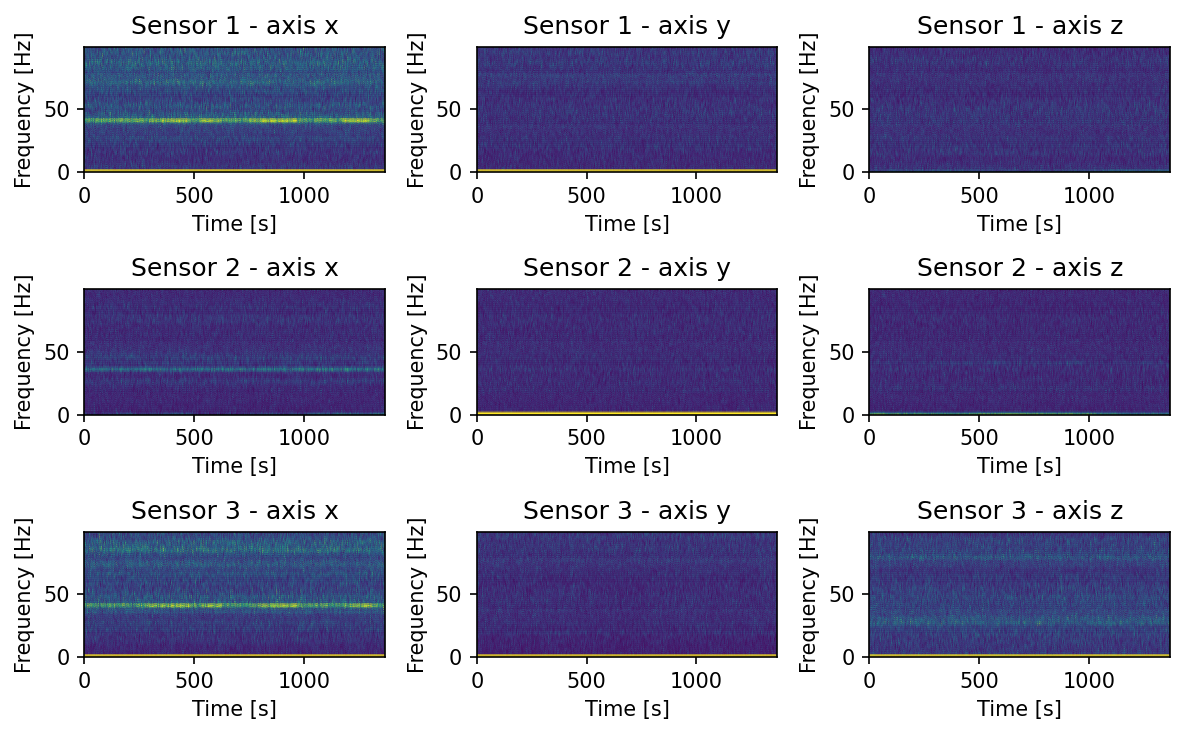

In [39]:
begin = begin_quiescent
end = end_quiescent

fig, ax = plt.subplots(3, 3, dpi=150, figsize=(8, 5))
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    fs = 1 / np.mean(np.diff(Time(subdat["times"]).unix))
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"

        f, t, Zxx = stft(subdat[key], fs, "hamming", 128)

        ax[c][j].pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1e-4, shading="gouraud")
        ax[c][j].set(
            xlabel="Time [s]",
            ylabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
# fig.suptitle(f"FCU speed: {percentv}%")
fig.tight_layout()
fig.savefig(f"{plot_dir}/spectrogram-still-{vms_date}-{slew_azi}-.png")

## Analyze tracking events

In [40]:
# Find events durint which the TMA is in tracking mode
tracks = [e for e in events if e.type == TMAState.TRACKING]
print(f"We found {len(tracks)} events where the TMA is in tracking mode")

We found 617 events where the TMA is in tracking mode


In [41]:
# Filter the list of tracks in order to keep the ones that are fully contained within the day corresponding to the hdf5 file.
date_min = Time(f"{vms_date} 00:00:00.00").unix
date_end = Time(f"{vms_date} 23:59:59.00").unix
sel_tracks = [
    tracks[i]
    for i in range(len(tracks))
    if (tracks[i].begin.unix > date_min and tracks[i].end.unix < date_end)
]
print(f"Selected {len(sel_tracks)} tracks out of {len(tracks)} for {dayObs}")

Selected 231 tracks out of 617 for 20231221


In [42]:
# This is the track that we are going to analyze
track_select = 220

# Get rid of a small delta_t before and after the selected slew in order to be sure that the TMA is settled
delta_t = TimeDelta(0, format="sec")
start_track = sel_tracks[track_select].begin - delta_t
end_track = sel_tracks[track_select].end + delta_t
print(f"Selected track - start: {start_track.datetime64} - end: {end_track.datetime64}")

Selected track - start: 2023-12-21T04:10:23.560689688 - end: 2023-12-21T04:11:05.575988531


In [43]:
print(
    sel_tracks[track_select].begin.datetime64, sel_tracks[track_select].end.datetime64
)

2023-12-21T04:10:23.560689688 2023-12-21T04:11:05.575988531


In [44]:
sel_t = (vms_m1m3_data["times"] > start_track.datetime64) & (
    vms_m1m3_data["times"] < end_track.datetime64
)

In [45]:
df_azi = getEfdData(
    client, "lsst.sal.MTMount.azimuth", begin=start_track, end=end_track
)
df_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", begin=start_track, end=end_track
)
print(len(df_azi), len(df_ele))

465 465


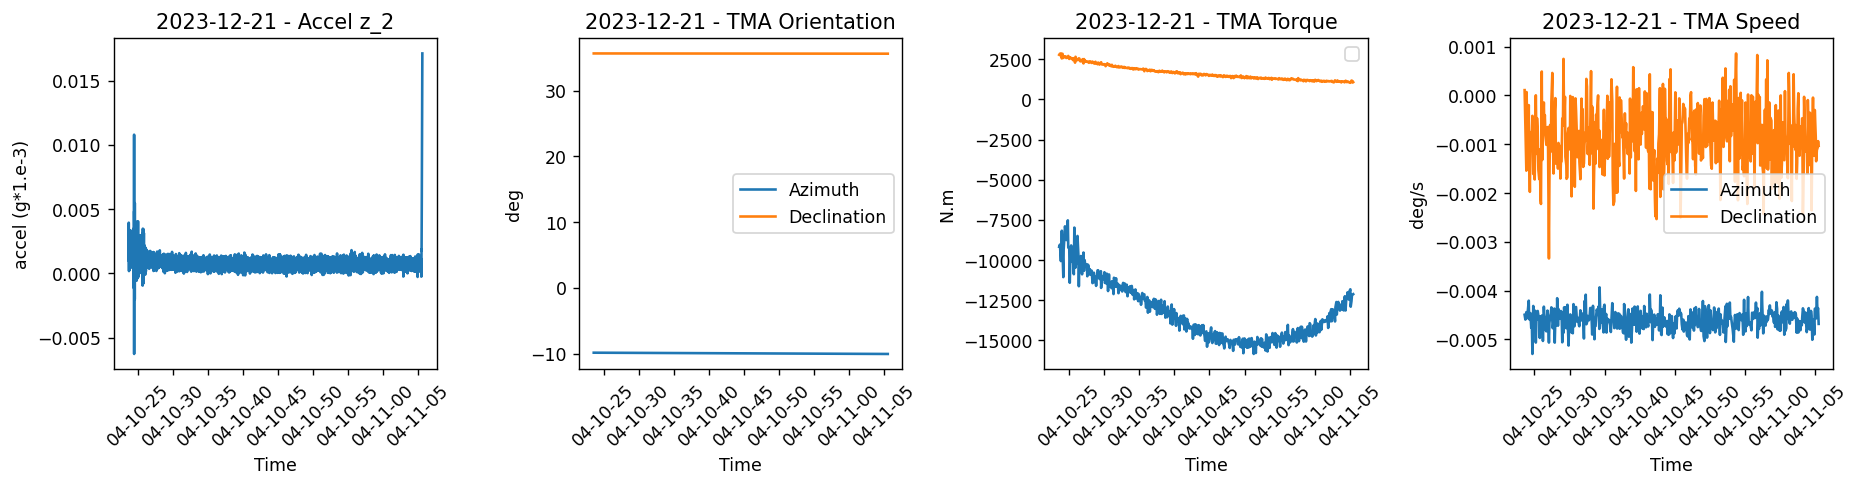

In [46]:
# Plot a few quantities to check that we have selected a good quality slew

fig, ax = plt.subplots(1, 4, dpi=125, figsize=(15, 4))
ax[0].plot(vms_m1m3_data["times"][sel_t], vms_m1m3_data["m1m3_x_3"][sel_t])
ax[0].set(ylabel="accel (g*1.e-3)", xlabel="Time", title=f"{vms_date} - Accel z_2")
ax[1].plot(df_azi.index, df_azi["actualPosition"], label="Azimuth")
ax[1].plot(df_ele.index, df_ele["actualPosition"], label="Declination")
ax[1].legend()
ax[1].set(ylabel="deg", xlabel="Time", title=f"{vms_date} - TMA Orientation")
ax[2].plot(df_azi.index, df_azi["actualTorque"])
ax[2].plot(df_azi.index, df_ele["actualTorque"])
ax[2].set(ylabel="N.m", xlabel="Time", title=f"{vms_date} - TMA Torque")
ax[2].legend()
ax[3].plot(df_azi.index, df_azi["actualVelocity"], label="Azimuth")
ax[3].plot(df_ele.index, df_ele["actualVelocity"], label="Declination")
ax[3].set(ylabel="deg/s", xlabel="Time", title=f"{vms_date} - TMA Speed")
ax[3].legend()
for i in range(4):
    ax[i].xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
    plt.setp(ax[i].get_xticklabels(), rotation=45)
fig.tight_layout()
fig.savefig(f"{plot_dir}/overview-tracking-{vms_date}-{track_select}-.png")

In [47]:
tracks[track_select]

dayObs: 20231220
seqNum: 529
type: TRACKING
endReason: SLEWING
duration: 42.10840129852295
begin: <Time object: scale='utc' format='unix' value=1703131687.9689245>
end: <Time object: scale='utc' format='unix' value=1703131730.0773258>
blockInfos: 
    dayObs: 20231220
    seqNum: 268
    blockNumber: 146
    blockId: BL146_O_20231220_000268
    begin: 2023-12-21T04:08:04.198
    end: 2023-12-21T04:08:46.984
    salIndices: [101574]
    tickets: ['SITCOM-885']
    states: 
       RUNNING @ 2023-12-21T04:08:04.198  
       RUNNING @ 2023-12-21T04:08:46.981  
        ENDING @ 2023-12-21T04:08:46.983  
          DONE @ 2023-12-21T04:08:46.984
    dayObs: 20231220
    seqNum: 269
    blockNumber: 146
    blockId: BL146_O_20231220_000269
    begin: 2023-12-21T04:08:48.988
    end: 2023-12-21T04:09:32.191
    salIndices: [101575]
    tickets: ['SITCOM-885']
    states: 
       RUNNING @ 2023-12-21T04:08:48.988  
       RUNNING @ 2023-12-21T04:09:32.188  
        ENDING @ 2023-12-21T04:09:32.1

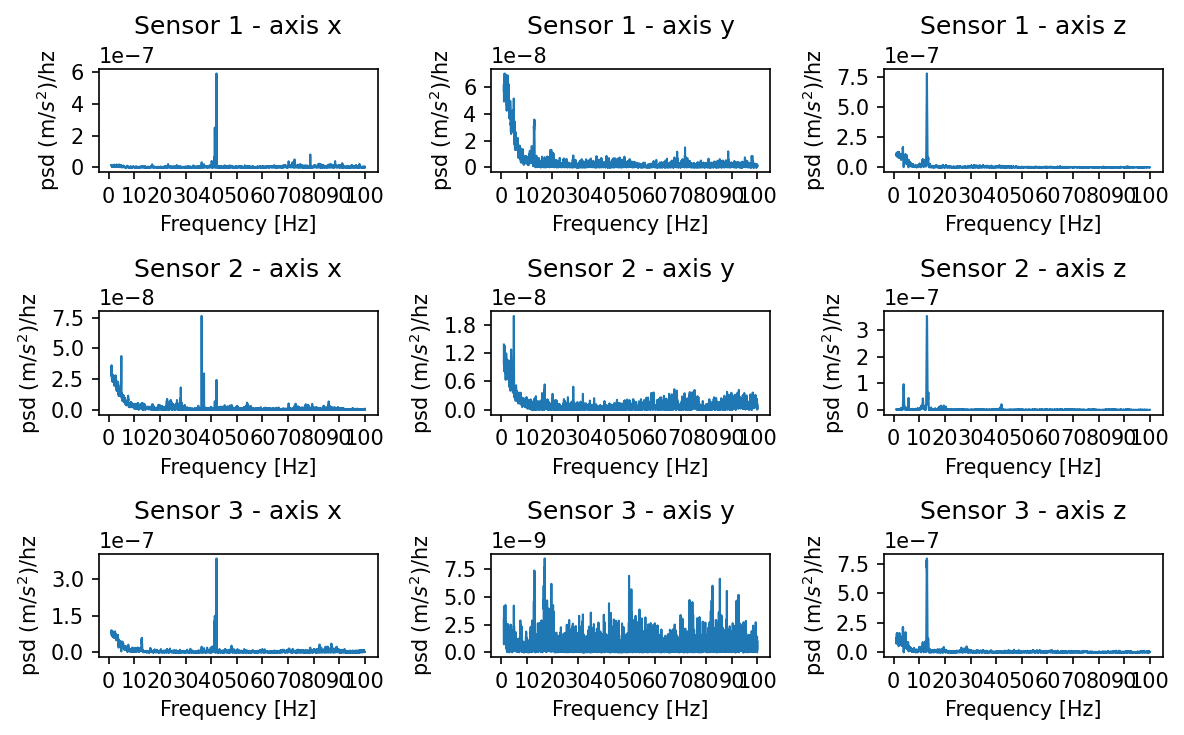

In [48]:
begin = start_track
end = end_track

fig, ax = plt.subplots(3, 3, dpi=150, figsize=(8, 5))
for c in range(3):

    subdat_sel = (vms_m1m3_data["times"] > begin.datetime64) & (
        vms_m1m3_data["times"] < end.datetime64
    )
    subdat = vms_m1m3_data.loc[subdat_sel, :]
    for j, axis in enumerate("xyz"):
        key = f"m1m3_{axis}_{c+1}"
        psds_df, disp = get_psd_and_dsd_for_vms(
            subdat[key],
            np.mean(np.diff(Time(subdat["times"]).unix)),
            g=True,
            min_freq=1,
        )

        x = psds_df["freq"]
        y = psds_df["accel_psd"]
        ax[c][j].plot(x, y, zorder=9, lw=1)
        ax[c][j].set_xticks(np.arange(0, 110, 10))
        ax[c][j].set(
            ylabel="psd (m/$s^2$)/hz",
            xlabel="Frequency [Hz]",
            title=f"Sensor {c+1} - axis {axis}",
        )
        yticks = ticker.MaxNLocator(4)
        ax[c][j].yaxis.set_major_locator(yticks)
        # ax[c][j].set_ylim([0, 1e-5])
        # ax[c][j].set_yscale("log")
# fig.suptitle(f"FCU speed: {percentv}%")
fig.tight_layout()

In [7]:
vms_date = "2023-06-28"
vms_m1m3_data = pd.read_parquet(
    f"/scratch/users/b/boutigny/vmsdata/2023/06/M1M3-{vms_date}T00:00.parquet"
)

In [54]:
vms_m1m3_data

times  m1m3_x_1  m1m3_y_1  m1m3_z_1  m1m3_x_2  \
0        2023-06-28 00:00:00.163828  0.000240  0.000633  0.000004  0.000050   
1        2023-06-28 00:00:00.164828  0.000237  0.000717  0.000050 -0.000084   
2        2023-06-28 00:00:00.165828  0.000705  0.000861  0.000112 -0.000092   
3        2023-06-28 00:00:00.166828  0.000343  0.000786  0.000061 -0.000122   
4        2023-06-28 00:00:00.167828  0.000607  0.000729  0.000038 -0.000225   
...                             ...       ...       ...       ...       ...   
17279745 2023-06-29 00:00:00.187183  0.000599  0.000675 -0.000019 -0.000088   
17279746 2023-06-29 00:00:00.188183  0.000511  0.000935  0.000225 -0.000004   
17279747 2023-06-29 00:00:00.189183  0.000641  0.000740  0.000168 -0.000099   
17279748 2023-06-29 00:00:00.190183  0.000468  0.000827  0.000244 -0.000109   
17279749 2023-06-29 00:00:00.191183  0.000511  0.000881  0.000126  0.000042   

          m1m3_z_2  m1m3_y_2  m1m3_x_3  m1m3_y_3  m1m3_z_3   total_1  \
0         0.000008  0.000736  0.000469  0.000397  0.000278  0.000677   
1        -0.000153  0.000599  0.000793  0.000458  0.000351  0.000757   
2        -0.000109  0.000644  0.000634  0.000356  0.000258  0.001119   
3        -0.000118  0.000648  0.000519  0.000423  0.000267  0.000860   
4        -0.000256  0.000519  0.000290  0.000389  0.000267  0.000949   
...            ...       ...       ...       ...       ...       ...   
17279745 -0.000187  0.000607  0.000526  0.000374  0.000244  0.000903   
17279746 -0.000095  0.000675  0.000504  0.000549  0.000374  0.001089   
17279747 -0.000149  0.000561  0.000740  0.000469  0.000412  0.000993   
17279748 -0.000081  0.000641  0.000420  0.000495  0.000346  0.000981   
17279749  0.000023  0.000744  0.000778  0.000561  0.000496  0.001026   

           total_2   total_3  
0         0.000738  0.000675  
1         0.000624  0.000981  
2         0.000660  0.000772  
3         0.000670  0.000721  
4         0.000621  0.000554  
...            ...       ...  
17279745  0.000641  0.000690  
17279746  0.000682  0.000834  
17279747  0.000589  0.000968  
17279748  0.000655  0.000736  
17279749  0.000745  0.001080  

[17279750 rows x 13 columns]

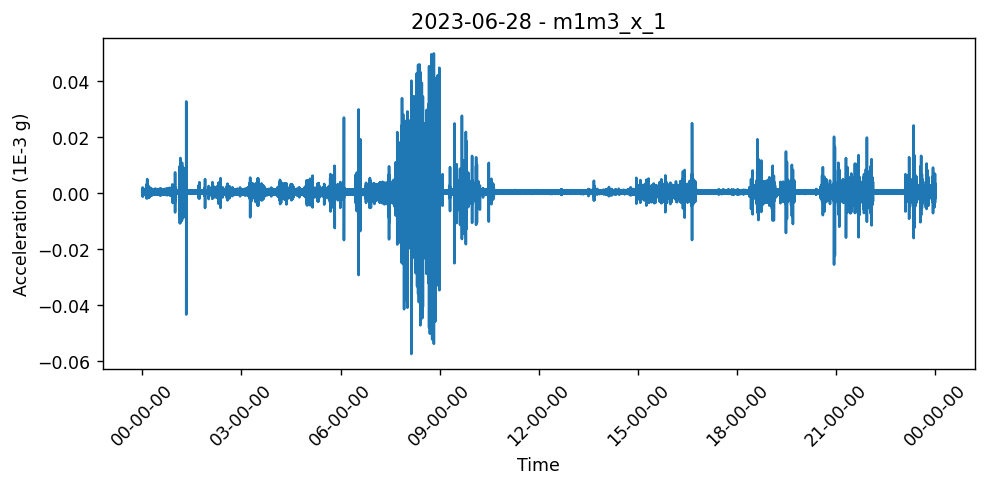

In [8]:
%matplotlib inline
# First look at the raw VMS data - We plot only 1 sensor and 1 axis because the full dataset is very large and requires too much memory
# to be displayed
fig, ax = plt.subplots(1, 1, dpi=125, figsize=(8, 4))
key = "m1m3_x_1"
ax.plot(vms_m1m3_data["times"], vms_m1m3_data[key])
ax.set(ylabel="Acceleration (1E-3 g)", xlabel="Time", title=f"{vms_date} - {key}")
ax.xaxis.set_major_formatter(DateFormatter("%H-%M-%S"))
plt.setp(ax.get_xticklabels(), rotation=45)
fig.tight_layout()
# fig.savefig(f"{plot_dir}/VMS-accel-{vms_date}.png")